In [ ]:
import cv2
import pywt
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from google.colab.patches import cv2_imshow
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_tv_chambolle
import pandas as pd
import scipy.stats
from google.colab.patches import cv2_imshow

import json



In [ ]:
!pip install pandas openpyxl

In [ ]:

def ppfft(f):
    #f is assumed N x N where N is even. If not, we just force it to be
    [h, w] = f.shape
    N = h
    f2 = f
    if h != w or np.mod(h, 2) == 1:
        N = int(np.ceil(max(h, w) / 2) * 2) #N is biggest dimension, but force even
        f2 = np.zeros([N, N])
        f2[N // 2 - int(h / 2):N // 2 - int(h / 2) + h, N // 2 - int(w / 2):N // 2 - int(w / 2) + w] = f
    ppff = np.zeros([2 * N, 2 * N]) * 1j

    #Constructing Quadrants 1 and 3
    ff = np.fft.fft(f2, N * 2, axis=0)
    ff = np.fft.fftshift(ff, 0)
    for i in range(-N, N):
        ppff[i + N, N - 1::-1] = fracfft(ff[i + N, :], i / (N ** 2), 1)

    #Constructing quadrants 2 and 4
    ff = np.fft.fft(f2, N * 2, axis=1)
    ff = np.fft.fftshift(ff, 1)
    ff = ff.T

    for i in range(-N, N):
        x = np.arange(0, N)
        factor = np.exp(1j * 2 * np.pi * x * (N / 2 - 1) * i / (N ** 2))
        ppff[i + N, N:2 * N] = fracfft(ff[i + N, :] * factor, i / (N ** 2))
    return ppff


def fracfft(f, alpha, centered=0):
    f = np.reshape(f.T, f.size)#flatten f
    N = len(f)#get length

    if centered == 1:
        x = np.arange(0, N)
        factor = np.exp(1j * np.pi * x * N * alpha)
        f = f * factor

    x = np.append(np.arange(0, N), np.arange(-N, 0))
    factor = np.exp(-1j * np.pi * alpha * x ** 2)
    ff = np.append(f, np.zeros(N))
    ff = ff * factor
    XX = np.fft.fft(ff)
    YY = np.fft.fft(np.conj(factor))

    result = np.fft.ifft(XX * YY)
    result = result * factor
    result = result[0:N]
    return result

def extract_statistical_features(image):
    """
    Extract statistical features from a grayscale image.

    Parameters:
    - image: 2D numpy array representing a grayscale image.

    Returns:
    - Dictionary containing statistical features.
    """
    features = {
        'mean': np.mean(image),
        'std': np.std(image),
        'min': np.min(image),
        'max': np.max(image),
        'skewness': skew(image.flatten()),
        'kurtosis': kurtosis(image.flatten())
    }
    return features


def ewt2d_LPscaling(radii, bound0, gamma):
    an = 1 / (2 * gamma * bound0)
    mbn = (1 - gamma) * bound0 # inner circle up to beginning of transtion
    pbn = (1 + gamma) * bound0 #end of transition

    scaling = 0 * radii #initiate w/ zeros
    scaling[radii < mbn] = 1
    scaling[radii >= mbn] = np.cos(np.pi * ewt_beta(an * (radii[radii >= mbn] - mbn)) / 2)
    scaling[radii > pbn] = 0
    return scaling



def ewt2d_LPwavelet(radii, bound1, bound2, gamma):
    wan = 1 / (2 * gamma * bound1) #scaling factor
    wam = 1 / (2 * gamma * bound2)
    wmbn = (1 - gamma) * bound1 #beginning of lower transition
    wpbn = (1 + gamma) * bound1 #end of lower transition
    wmbm = (1 - gamma) * bound2  #beginning of upper transition
    wpbm = (1 + gamma) * bound2 #end of upper transition

    wavelet = 0 * radii #initialize w/ zeros
    inside = (radii > wmbn) * (radii < wpbm)
    wavelet[inside] = 1.0 #set entire angular wedge equal to 1
    temp = inside*(radii >= wmbm) * (radii <= wpbm) #upper transition
    wavelet[temp] *= np.cos(np.pi * ewt_beta(wam * (radii[temp] - wmbm)) / 2)
    temp = inside * (radii >= wmbn) * (radii <= wpbn) #lower transition
    wavelet[temp] *= np.sin(np.pi * ewt_beta(wan * (radii[temp] - wmbn)) / 2)
    return wavelet

def extract_2d_statistical_features(image):
    # Calculate statistical features from the 2D image
    features = {}
    features['Mean'] = np.mean(image)
    features['StdDev'] = np.std(image)
    features['Skewness'] = skew(image.flatten())
    features['Kurtosis'] = kurtosis(image.flatten())
    return features

def ewt_beta(x):
    bm = (x >= 0) * (x <= 1) \
        * (x ** 4 * (35 - 84 * x + 70 * x ** 2 - 20 *x **3))
    bm += (x > 1)
    return bm

def ewt2d_LPFilterbank(bounds_scales, h, w):

    if h % 2 == 0:
        h += 1
        h_extended = 1
    else:
        h_extended = 0
    if w % 2 == 0:
        w += 1
        w_extended = 1
    else:
        w_extended = 0
    #First, we calculate gamma for scales
    gamma_scales = np.pi
    for k in range(0, len(bounds_scales) - 1):
        r = (bounds_scales[k + 1] - bounds_scales[k]) / (bounds_scales[k + 1] + bounds_scales[k])
        if r < gamma_scales and r > 1e-16:
            gamma_scales = r
    r = (np.pi - bounds_scales[-1]) / (np.pi + bounds_scales[-1]) #check last bound
    if r < gamma_scales and r > 1e-16:
        gamma_scales = r

    if gamma_scales > bounds_scales[0]:     #check first bound
        gamma_scales = bounds_scales[0]
    gamma_scales *= (1 - 1 / max(h, w)) #guarantees that we have strict inequality
    radii = np.zeros([h, w])

    h_center = h // 2 + 1
    w_center = w // 2 + 1
    for i in range(0, h):
        for j in range(0, w):
            ri = (i + 1.0 - h_center) * np.pi / h_center
            rj = (j + 1.0 - w_center) * np.pi / w_center
            radii[i, j] = np.sqrt(ri ** 2 + rj ** 2)

    mfb = []
    mfb.append(ewt2d_LPscaling(radii, bounds_scales[0], gamma_scales))
    for i in range(0, len(bounds_scales) - 1):
        mfb.append(ewt2d_LPwavelet(radii, bounds_scales[i], bounds_scales[i + 1], gamma_scales))
    mfb.append(ewt2d_LPwavelet(radii, bounds_scales[-1], 2 * np.pi, gamma_scales))

    if h_extended == 1: #if we extended the height of the image, trim
        h -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][0:-1, :]
    if w_extended == 1: #if we extended the width of the image, trim
        w -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][:, 0:-1]
    #invert the fftshift since filters are centered
    for i in range(0, len(mfb)):
        mfb[i] = np.fft.ifftshift(mfb[i])

    #Resymmetrize for even images
    if h_extended == 1:
        s = np.zeros(w)
        if w % 2 == 0:
            mfb[-1][h // 2, 1:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2 - 1:0:-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 1:w // 2] /= np.sqrt(s[1:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
        else:
            mfb[-1][h // 2, 0:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2-1::-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 0:w // 2]  /= np.sqrt(s[0:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
    if w_extended == 1:
        s = np.zeros(h)
        if h%2 == 0:
            mfb[-1][1:h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1:0:-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][1:h // 2, w // 2] /= np.sqrt(s[1:h // 2])
            mfb[-1][h // 2 + 1:, w // 2] /= np.sqrt(s[h // 2 + 1:])
        else:
            mfb[-1][0 : h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1::-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][0:h // 2, w // 2] /= s[0:h // 2]
            mfb[-1][h // 2 + 1:, w // 2] /= s[h // 2 + 1:]
    return mfb


def fractal_dimension(image):
    """
    Compute the fractal dimension of an image using the box-counting method.

    Parameters:
        image (numpy.ndarray): Input grayscale image.

    Returns:
        float: Fractal dimension of the image.
    """
    # Binarize the image
    binary_image = image > np.mean(image)

    # Create a grid of different box sizes
    sizes = 2**np.arange(4, int(np.log(min(image.shape))/np.log(2)))

    # Count the number of boxes needed to cover the image for each box size
    counts = []
    for size in sizes:
        count = 0
        for i in range(0, image.shape[0], size):
            for j in range(0, image.shape[1], size):
                if np.sum(binary_image[i:i+size, j:j+size]) > 0:
                    count += 1
        counts.append(count)

    # Compute the fractal dimension using linear regression
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]



# Function to compute 2D Teager-Kaiser energy
def taeger_kaiser_energy_2d(image):
    """
    Calculate the 2D Taege-Kaiser energy of a grayscale image.

    Parameters:
    - image: 2D numpy array representing a grayscale image.

    Returns:
    - Taege-Kaiser energy value.
    """
    # Compute Teager-Kaiser energy
    energy = np.sum(image[1:-1, 1:-1] ** 2 - image[0:-2, 1:-1] * image[2:, 1:-1] -
                     image[1:-1, 0:-2] * image[1:-1, 2:])

    return energy


def mca_2d(image):
    """
    Perform 2D Morphological Component Analysis (MCA) on a grayscale image.

    Parameters:
    - image: 2D numpy array representing a grayscale image.

    Returns:
    - List of morphologically decomposed images.
    """
    # Define structuring element for morphological operations
    kernel = np.ones((3, 3), np.uint8)

    # Perform erosion and dilation to obtain morphological decomposition
    eroded = cv2.erode(image, kernel, iterations=1)
    dilated = cv2.dilate(image, kernel, iterations=1)

    # Subtract the eroded image from the original and the dilated image
    mca_image_1 = image - eroded
    mca_image_2 = dilated - image

    return [mca_image_1, mca_image_2]
def display_images(images, titles):
    """
    Display a list of images with corresponding titles.

    Parameters:
    - images: List of numpy arrays representing images.
    - titles: List of titles for the images.
    """
    num_images = len(images)
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_0/"

# Define the directory to save results
results_dir = "/content/drive/MyDrive/Colab Notebooks/results/"
os.makedirs(results_dir, exist_ok=True)

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 100 image files
image_files = image_files[:2]

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image (you may need to adjust the condition based on your dataset)
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Plot mean magnitude
        plt.plot(mean_ppff)
        plt.title("Mean Magnitude of ppfft")
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude")
        plt.show()

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        plt.figure()
        plt.imshow(grayscale_image, cmap='gray')
        plt.title(f"Grayscale image of Original")
        plt.show()

        # Display filtered images
        plt.figure(figsize=(12, 12))
        for m in range(len(mfb)):
            plt.subplot(4, 4, m+1)
            plt.imshow(ewtLP[m], cmap='gray')
            plt.title(f"Filtered Image {m+1}")
            plt.axis('off')
        plt.show()

        # Display filtered images with surface plots
        fig = plt.figure(figsize=(12, 12))
        for m in range(len(mfb)):
            ax = fig.add_subplot(4, 4, m+1, projection='3d')

            # Generate X and Y coordinates
            x = np.arange(ewtLP[m].shape[1])
            y = np.arange(ewtLP[m].shape[0])
            X, Y = np.meshgrid(x, y)

            # Plot surface
            ax.plot_surface(X, Y, ewtLP[m], cmap='viridis')

            ax.set_title(f"Filtered Image {m+1}")
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Intensity')

        plt.show()




        # Extract statistical features for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        print("Statistical features for grayscale image:")
        for key, value in statistical_features_grayscale.items():
            print(f"{key}: {value}")

        # Extract statistical features for each EWT coefficient
        statistical_features_ewtLP = []
        for coeff in ewtLP:
            statistical_features_ewtLP.append(extract_statistical_features(coeff))

        # Display statistical features for each EWT coefficient
        for i, features in enumerate(statistical_features_ewtLP):
            print(f"\nStatistical features for EWT coefficient {i+1}:")
            for key, value in features.items():
                print(f"{key}: {value}")

        # Compute and display the fractal dimension for the grayscale image
        fractal_dimension_grayscale = fractal_dimension(grayscale_image)
        print("Fractal dimension of grayscale image:", fractal_dimension_grayscale)

        # Compute and display the fractal dimension for each EWT coefficient
        fractal_dimensions_ewtLP = []
        for i, coeff in enumerate(ewtLP):
            fractal_dimensions_ewtLP.append(fractal_dimension(coeff))
            print(f"Fractal dimension of EWT coefficient {i+1}: {fractal_dimensions_ewtLP[-1]}")



       # Compute 2D Teager-Kaiser energy for the first filtered image
        tk_energy = taeger_kaiser_energy_2d(grayscale_image)
        print("2D Teager-Kaiser Energy of grayscale_image:", tk_energy)

       # Calculate and print Teager-Kaiser energy value for each filtered image
        for i, filtered_image in enumerate(ewtLP):
            tk_energy = taeger_kaiser_energy_2d(filtered_image)
            print(f"Teager-Kaiser energy value for filtered image {i+1}: {tk_energy}")


        # Perform MCA on the grayscale image
    #    mca_grayscale_image = mca_2d(grayscale_image)

        # Perform MCA on each EWT coefficient
      #  mca_ewtLP = []
       # for coeff in ewtLP:
        #    mca_ewtLP.append(mca_2d(coeff))

        # Display MCA results for the grayscale image
        #mca_grayscale_titles = ["MCA Component 1", "MCA Component 2"]
        #display_images(mca_grayscale_image, mca_grayscale_titles)

        # Display MCA results for each EWT coefficient
      #  for i, coeff_mca in enumerate(mca_ewtLP):
      #      coeff_titles = [f"MCA Component 1 - Coeff {i+1}", f"MCA Component 2 - Coeff {i+1}"]
      #      display_images(coeff_mca, coeff_titles)



###############   Filtered Image

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Display filtered images of ewtLP[0]
        plt.figure(figsize=(12, 12))
        for m in range(len(mfb)):
            plt.subplot(4, 4, m+1)
            plt.imshow(ewtLP0_filtered[m], cmap='gray')
            plt.title(f"Filtered ewtLP[0] Image {m+1}")
            plt.axis('off')
        plt.show()

        # Display filtered images of ewtLP[0] with surface plots
        fig = plt.figure(figsize=(12, 12))
        for m in range(len(mfb)):
            ax = fig.add_subplot(4, 4, m+1, projection='3d')

            # Generate X and Y coordinates
            x = np.arange(ewtLP0_filtered[m].shape[1])
            y = np.arange(ewtLP0_filtered[m].shape[0])
            X, Y = np.meshgrid(x, y)

            # Plot surface
            ax.plot_surface(X, Y, ewtLP0_filtered[m], cmap='viridis')

            ax.set_title(f"Filtered ewtLP[0] Image {m+1}")
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Intensity')

        plt.show()

        # Extract statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            print(f"Statistical features for ewtLP[0] filtered image {idx+1}:")
            for key, value in statistical_features_filtered.items():
                print(f"{key}: {value}")

        # Compute and display the fractal dimension for each EWT coefficient
        fractal_dimensions_ewtLP0 = []
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dimensions_ewtLP0.append(fractal_dimension(coeff))
            print(f"Fractal dimension of ewtLP[0] coefficient {i+1}: {fractal_dimensions_ewtLP0[-1]}")

        # Compute 2D Teager-Kaiser energy for the first filtered image
        tk_energy = taeger_kaiser_energy_2d(ewtLP[0])
        print("2D Teager-Kaiser Energy of ewtLP[0]:", tk_energy)

        # Calculate and print Teager-Kaiser energy value for each filtered image
        for i, filtered_image in enumerate(ewtLP0_filtered):
            tk_energy = taeger_kaiser_energy_2d(filtered_image)
            print(f"Teager-Kaiser energy value for ewtLP[0] filtered image {i+1}: {tk_energy}")

        # Perform MCA on ewtLP[0]
   #     mca_ewtLP0 = mca_2d(ewtLP[0])

        # Perform MCA on each EWT coefficient of ewtLP[0]
    #    mca_ewtLP0_filtered = []
     #   for coeff in ewtLP0_filtered:
      #      mca_ewtLP0_filtered.append(mca_2d(coeff))

        # Display MCA results for ewtLP[0]
 #       mca_ewtLP0_titles = ["MCA Component 1 - ewtLP[0]", "MCA Component 2 - ewtLP[0]"]
#        display_images(mca_ewtLP0, mca_ewtLP0_titles)

        # Display MCA results for each EWT coefficient of ewtLP[0]
  #      for i, coeff_mca in enumerate(mca_ewtLP0_filtered):
   #         coeff_titles = [f"MCA Component 1 - Coeff {i+1}", f"MCA Component 2 - Coeff {i+1}"]
    #        display_images(coeff_mca, coeff_titles)



  ########           ewtLP0_filtered[0]



         # Apply EWT2D filter bank to ewtLP0_filtered[0]
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered0_refiltered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered0_refiltered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

        # Display filtered images of ewtLP0_filtered[0]
        plt.figure(figsize=(12, 12))
        for m in range(len(mfb)):
            plt.subplot(4, 4, m+1)
            plt.imshow(ewtLP0_filtered0_refiltered[m], cmap='gray')
            plt.title(f"Filtered ewtLP0_filtered[0] Image {m+1}")
            plt.axis('off')
        plt.show()

        # Display filtered images of ewtLP0_filtered[0] with surface plots
        fig = plt.figure(figsize=(12, 12))
        for m in range(len(mfb)):
            ax = fig.add_subplot(4, 4, m+1, projection='3d')

            # Generate X and Y coordinates
            x = np.arange(ewtLP0_filtered0_refiltered[m].shape[1])
            y = np.arange(ewtLP0_filtered0_refiltered[m].shape[0])
            X, Y = np.meshgrid(x, y)

            # Plot surface
            ax.plot_surface(X, Y, ewtLP0_filtered0_refiltered[m], cmap='viridis')

            ax.set_title(f"Filtered ewtLP0_filtered[0] Image {m+1}")
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Intensity')

        plt.show()

        # Extract statistical features for the filtered images of ewtLP0_filtered[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered0_refiltered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            print(f"Statistical features for ewtLP0_filtered[0] filtered image {idx+1}:")
            for key, value in statistical_features_filtered.items():
                print(f"{key}: {value}")

        # Compute and display the fractal dimension for each EWT coefficient of ewtLP0_filtered[0]
        fractal_dimensions_ewtLP0_filtered0 = []
        for i, coeff in enumerate(ewtLP0_filtered0_refiltered):
            fractal_dimensions_ewtLP0_filtered0.append(fractal_dimension(coeff))
            print(f"Fractal dimension of ewtLP0_filtered[0] coefficient {i+1}: {fractal_dimensions_ewtLP0_filtered0[-1]}")

        # Compute 2D Teager-Kaiser energy for the first filtered image of ewtLP0_filtered[0]
        tk_energy = taeger_kaiser_energy_2d(ewtLP0_filtered[0])
        print("2D Teager-Kaiser Energy of ewtLP0_filtered[0]:", tk_energy)

        # Calculate and print Teager-Kaiser energy value for each filtered image of ewtLP0_filtered[0]
        for i, filtered_image in enumerate(ewtLP0_filtered0_refiltered):
            tk_energy = taeger_kaiser_energy_2d(filtered_image)
            print(f"Teager-Kaiser energy value for ewtLP0_filtered[0] filtered image {i+1}: {tk_energy}")

        # Perform MCA on ewtLP0_filtered[0]
     #   mca_ewtLP0_filtered0 = mca_2d(ewtLP0_filtered[0])

        # Perform MCA on each EWT coefficient of ewtLP0_filtered[0]
      #  mca_ewtLP0_filtered0_refiltered = []
       # for coeff in ewtLP0_filtered0_refiltered:
        #    mca_ewtLP0_filtered0_refiltered.append(mca_2d(coeff))

        # Display MCA results for ewtLP0_filtered[0]
        #mca_ewtLP0_filtered0_titles = ["MCA Component 1 - ewtLP0_filtered[0]", "MCA Component 2 - ewtLP0_filtered[0]"]
       # display_images(mca_ewtLP0_filtered0, mca_ewtLP0_filtered0_titles)

        # Display MCA results for each EWT coefficient of ewtLP0_filtered[0]
        #for i, coeff_mca in enumerate(mca_ewtLP0_filtered0_refiltered):
         #   coeff_titles = [f"MCA Component 1 - Coeff {i+1}", f"MCA Component 2 - Coeff {i+1}"]
          #  display_images(coeff_mca, coeff_titles)










ValueError: Mountpoint must not already contain files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


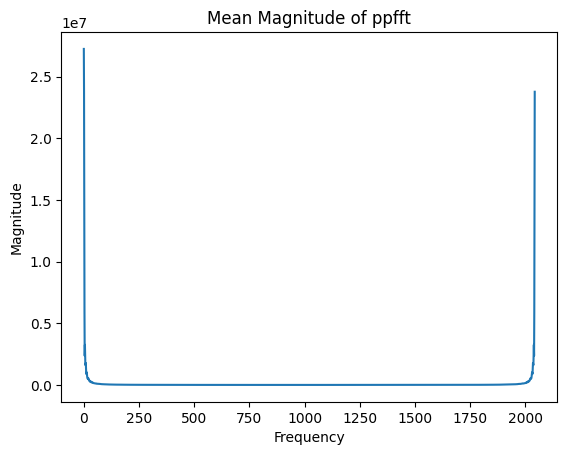

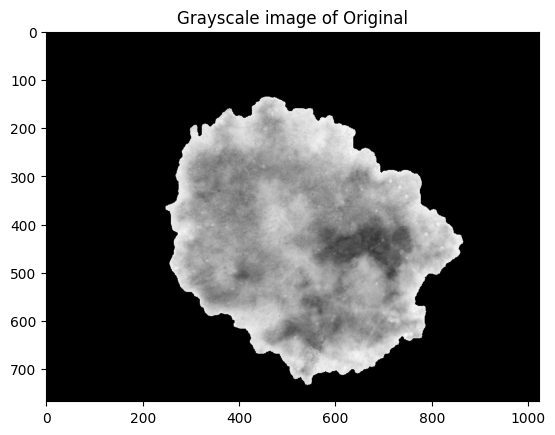

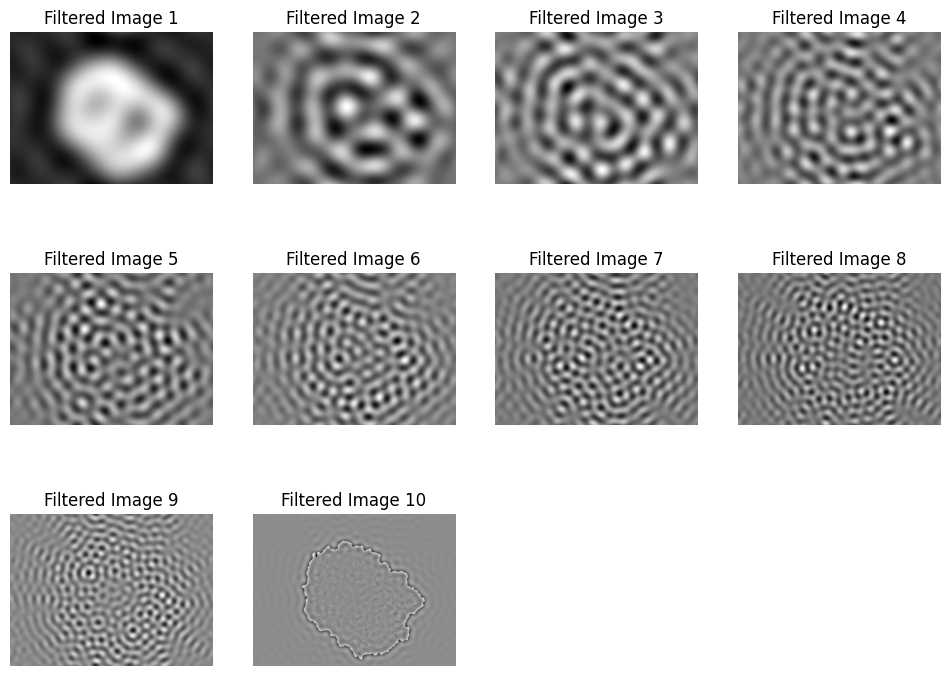

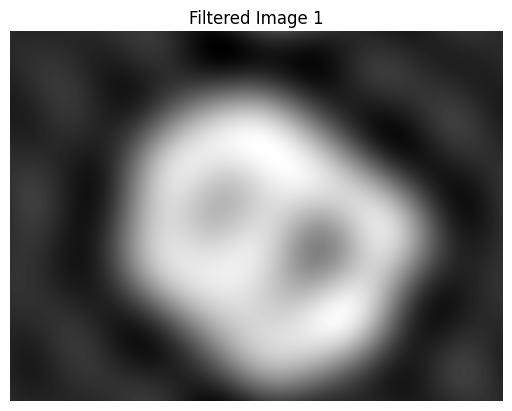

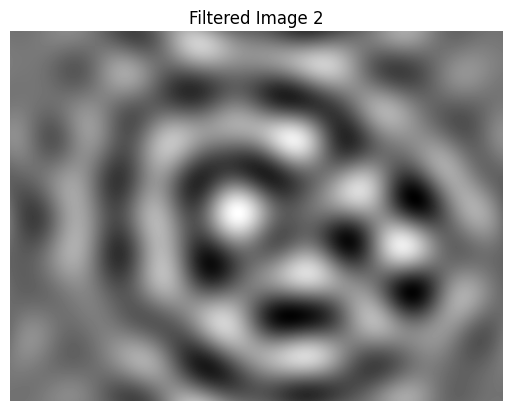

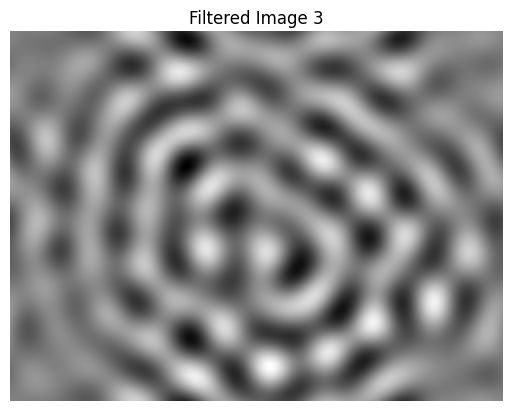

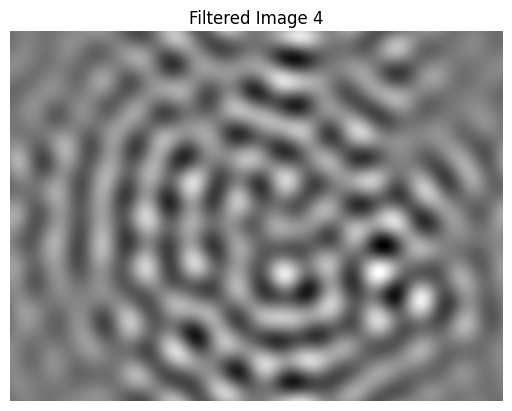

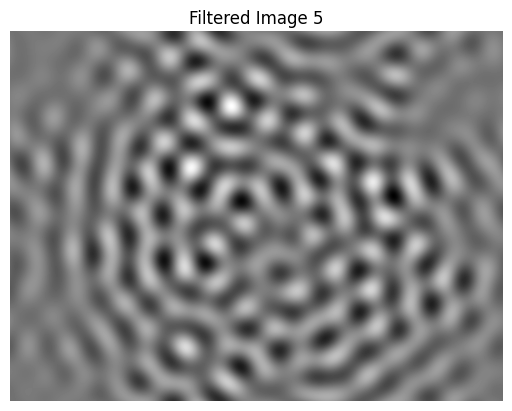

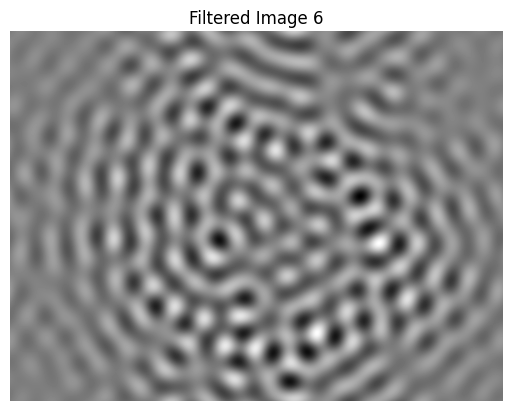

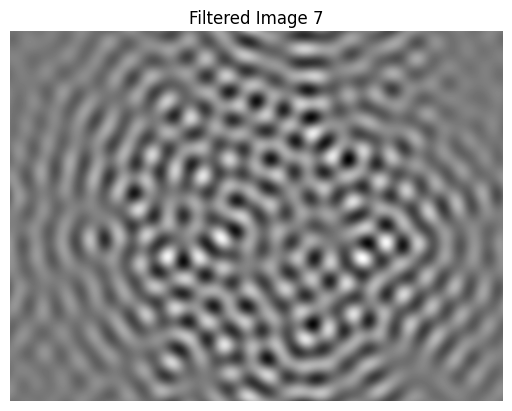

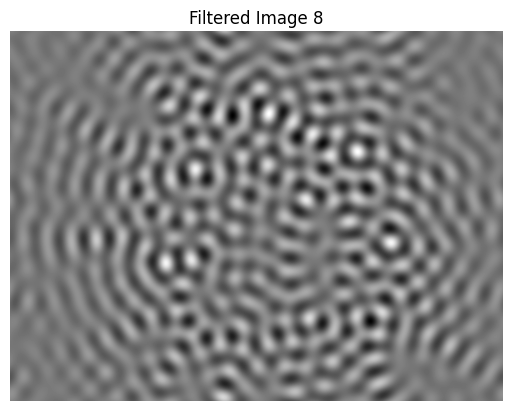

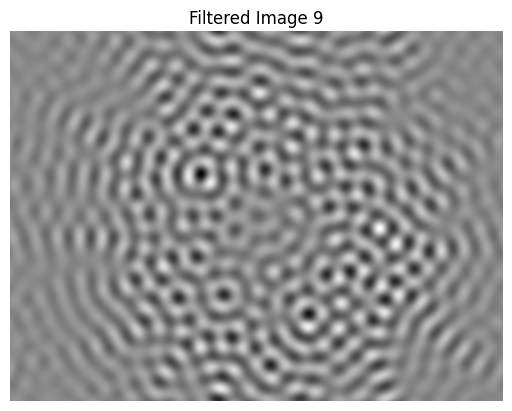

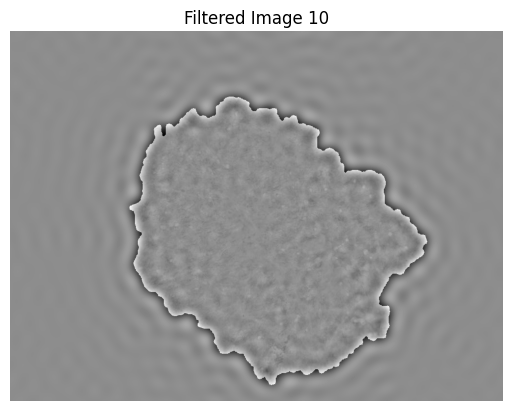

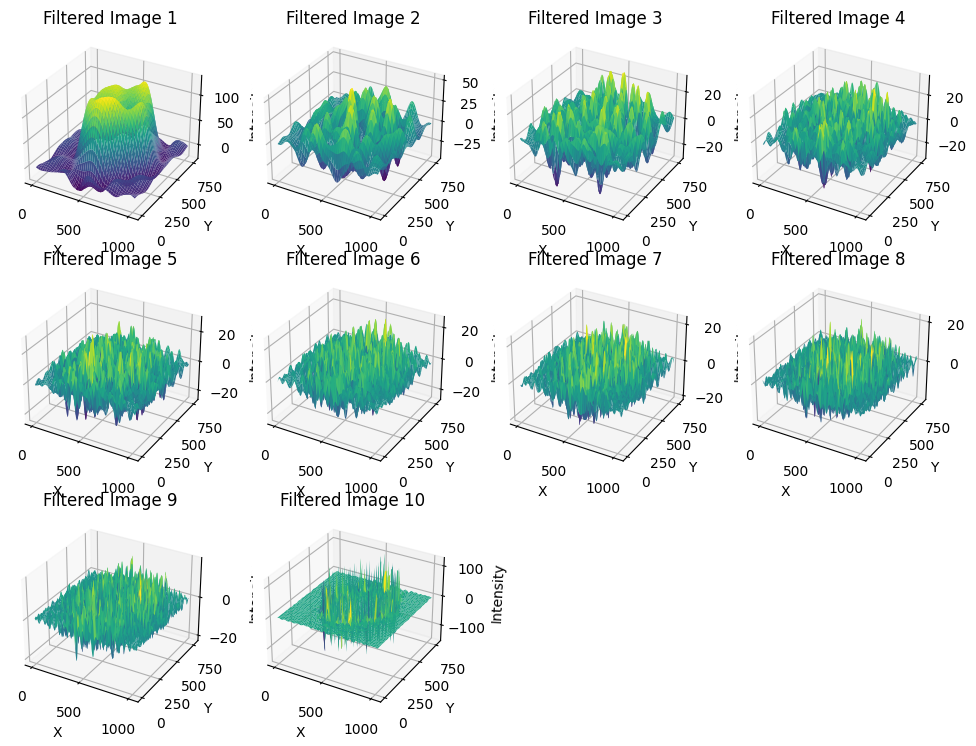

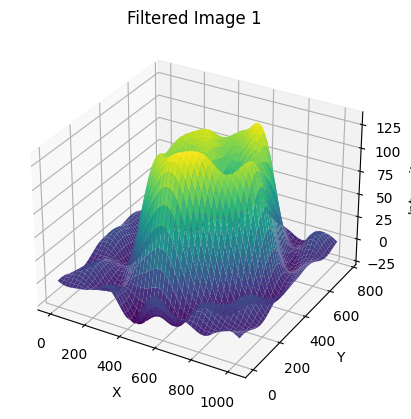

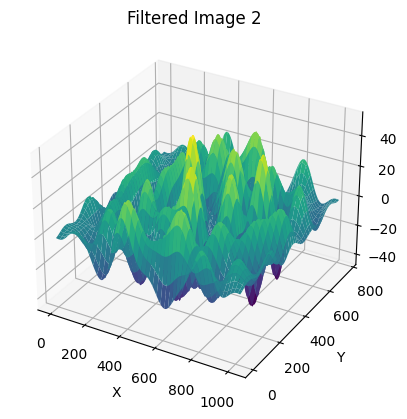

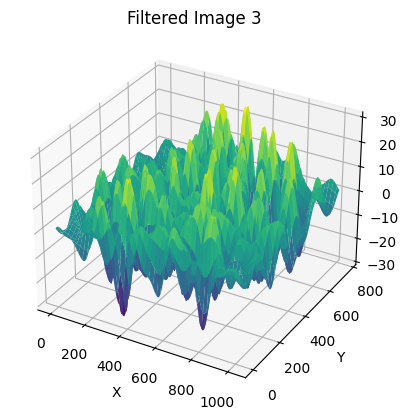

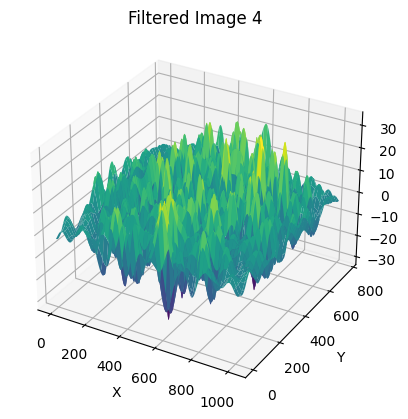

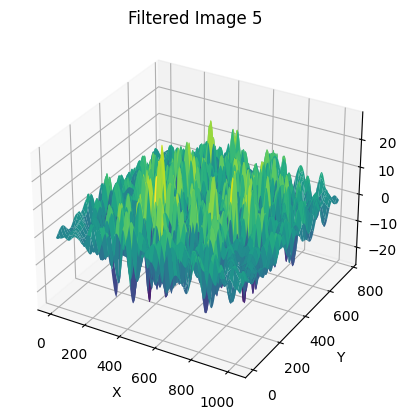

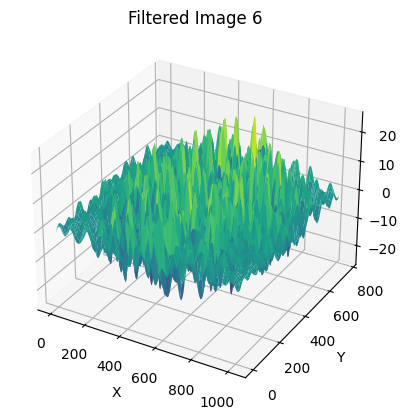

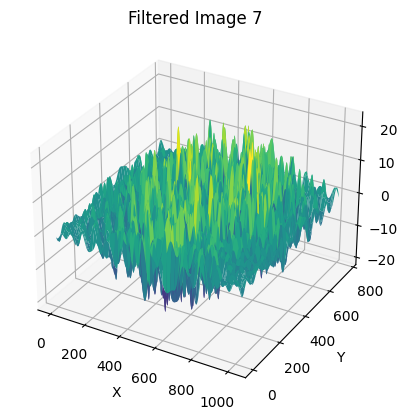

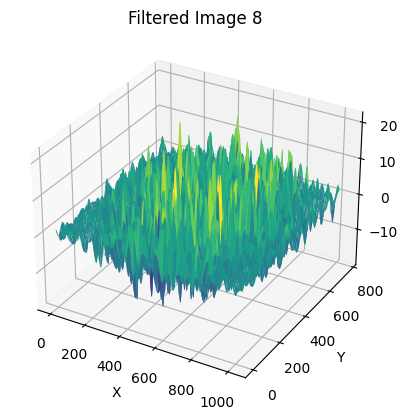

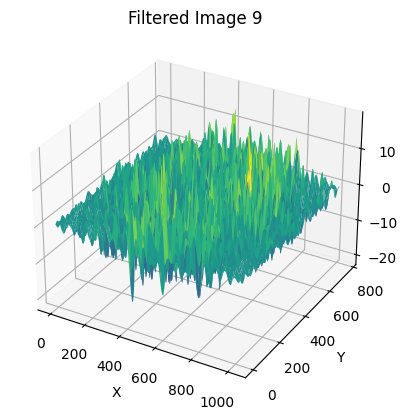

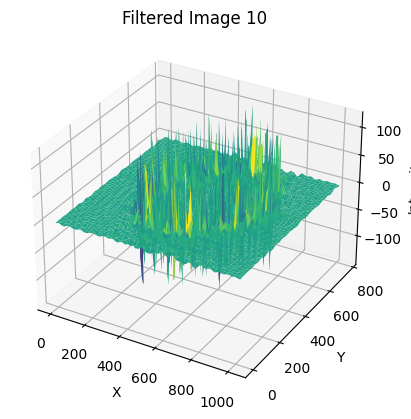

Statistical features for grayscale image:
mean: 34.772328205808584
std: 54.62156339583441
min: 0
max: 173
skewness: 1.06479564584071
kurtosis: -0.612988350956003

Statistical features for EWT coefficient 1:
mean: 34.77232820580859
std: 47.89246605450138
min: -25.802362047802358
max: 135.09137433403484
skewness: 0.7161991939551327
kurtosis: -1.1321784960736716

Statistical features for EWT coefficient 2:
mean: 5.917306836356269e-17
std: 15.057116873338122
min: -45.27577158723568
max: 53.39805387569984
skewness: 0.04769080843273002
kurtosis: 0.27795872776017205

Statistical features for EWT coefficient 3:
mean: -1.044230618180518e-17
std: 9.362124621074834
min: -30.02185622792384
max: 30.745136132159118
skewness: 0.018874688637422553
kurtosis: -0.09928426136041457

Statistical features for EWT coefficient 4:
mean: 1.044230618180518e-17
std: 8.366143536742396
min: -32.3783409719055
max: 34.46593164563192
skewness: 0.08367053790732655
kurtosis: 0.4160811234206827

Statistical features for 

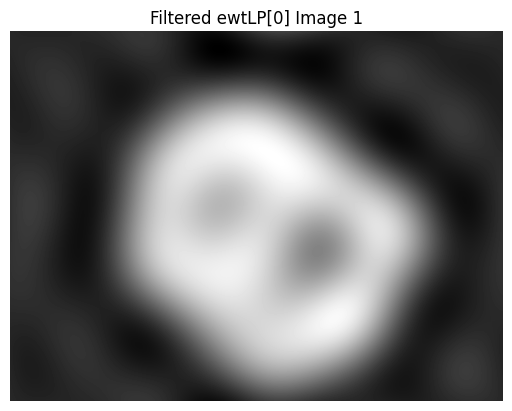

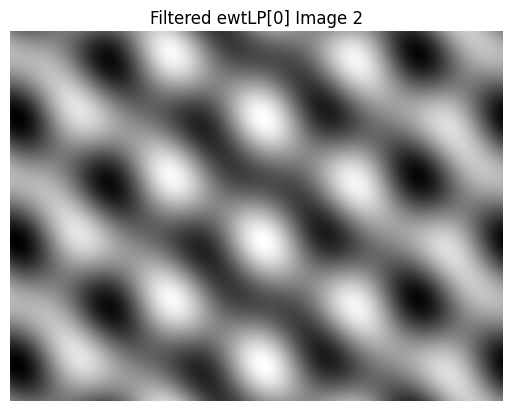

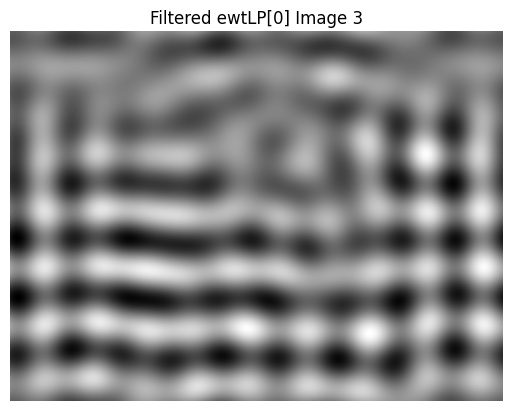

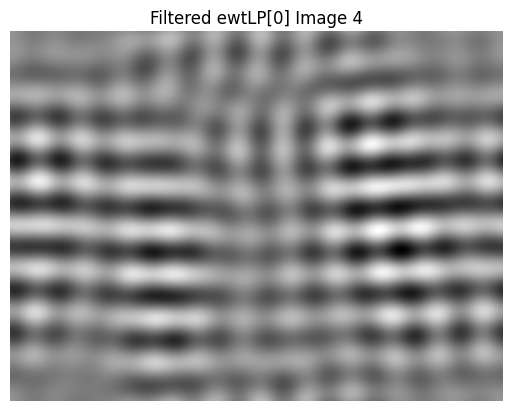

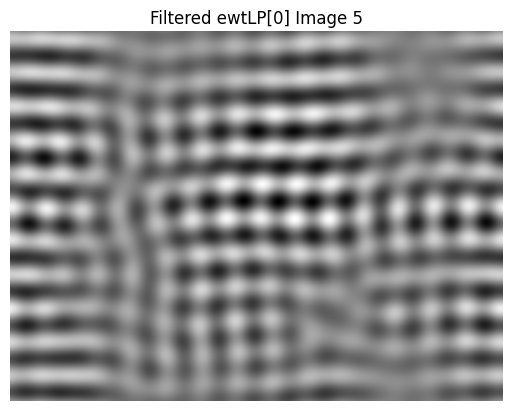

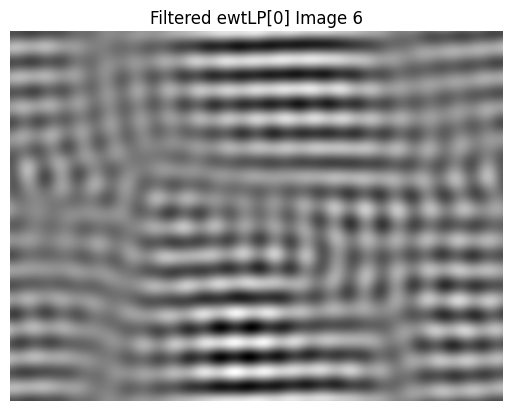

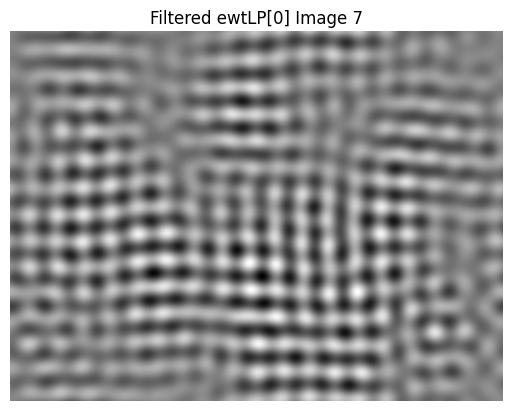

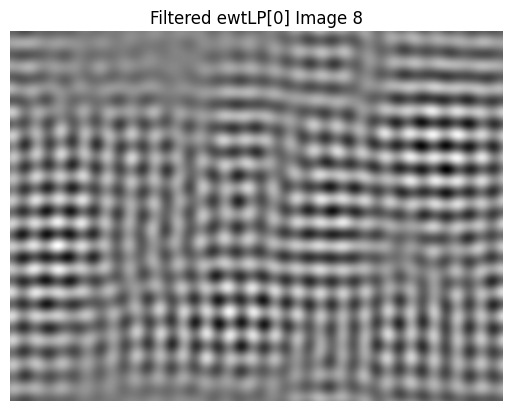

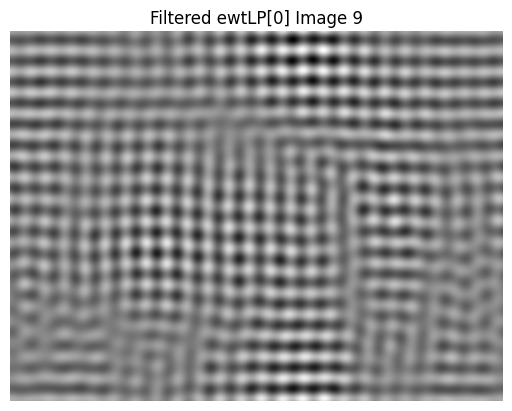

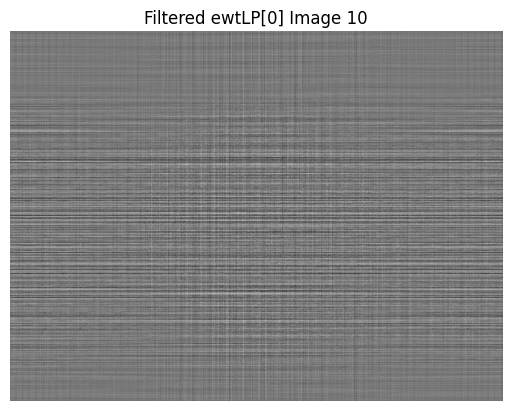

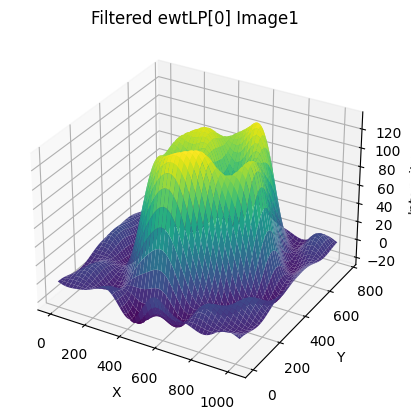

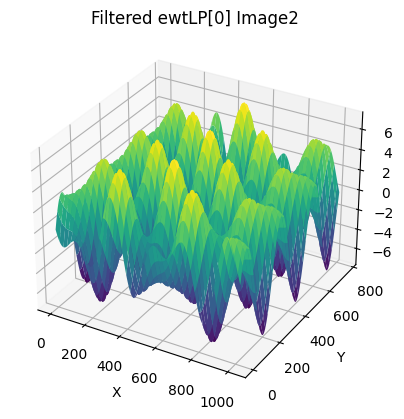

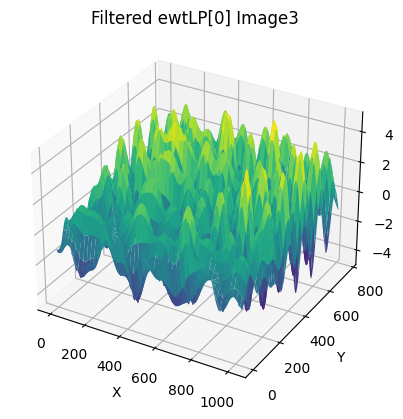

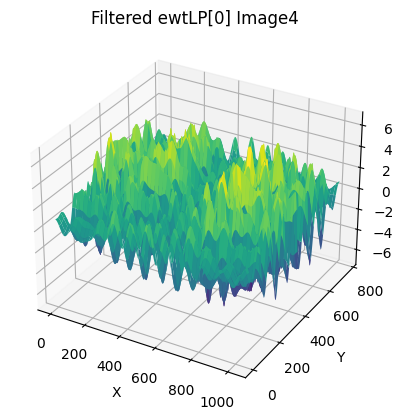

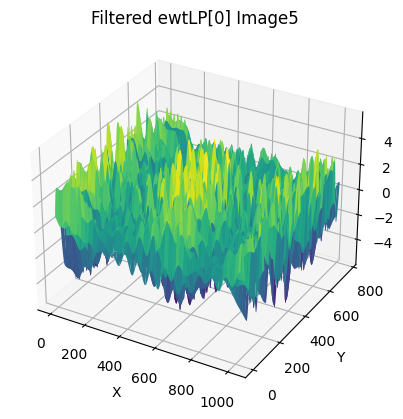

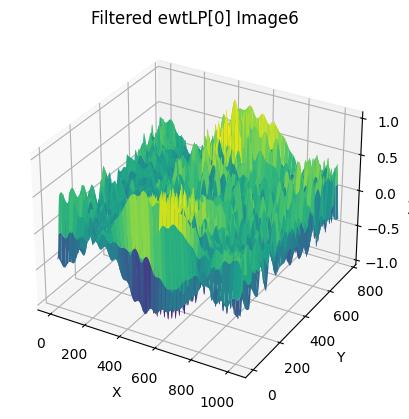

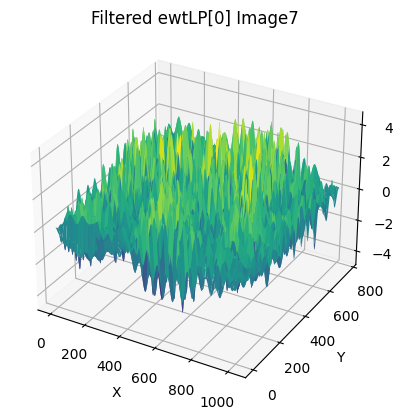

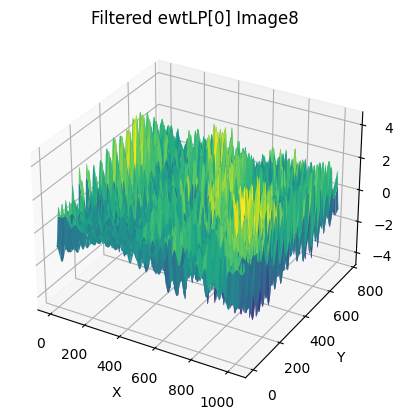

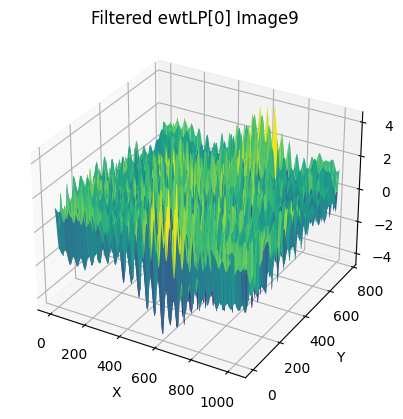

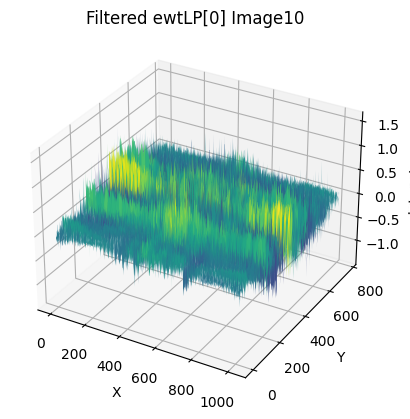

Statistical features for ewtLP[0] filtered image 1:
mean: 34.77232820580859
std: 47.7820325855056
min: -24.86995516319534
max: 134.56124922387556
skewness: 0.7206486798075658
kurtosis: -1.1260750082482698
Statistical features for ewtLP[0] filtered image 2:
mean: -6.497434957567668e-17
std: 3.250487160295797
min: -7.365100718511215
max: 7.365100718511215
skewness: 1.5462847099182157e-16
kurtosis: -0.7882736449381658
Statistical features for ewtLP[0] filtered image 3:
mean: -3.0915436675268576e-33
std: 1.8114242527193394e-15
min: -4.821909260917193e-15
max: 5.081753582743339e-15
skewness: -0.004352521277279321
kurtosis: -0.4235695788622884
Statistical features for ewtLP[0] filtered image 4:
mean: -1.030514555842286e-33
std: 2.148897019778875e-15
min: -7.21115801407112e-15
max: 6.9284032017515605e-15
skewness: 0.0003784024694316058
kurtosis: -0.1330523658821985
Statistical features for ewtLP[0] filtered image 5:
mean: 5.15257277921143e-34
std: 1.8574965036790885e-15
min: -5.83084264627325

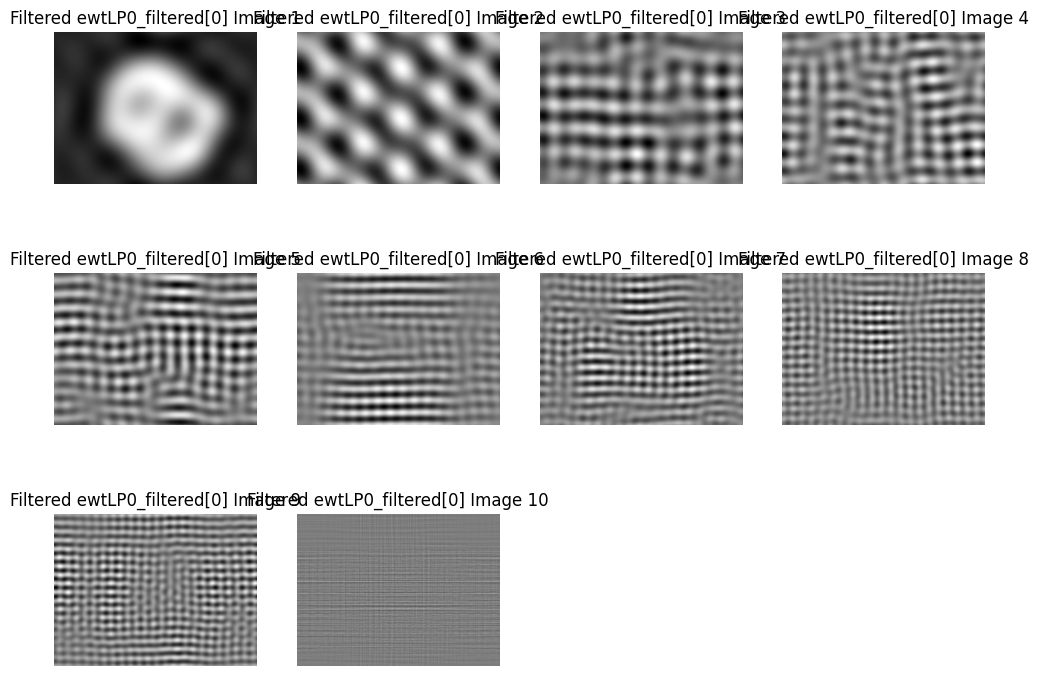

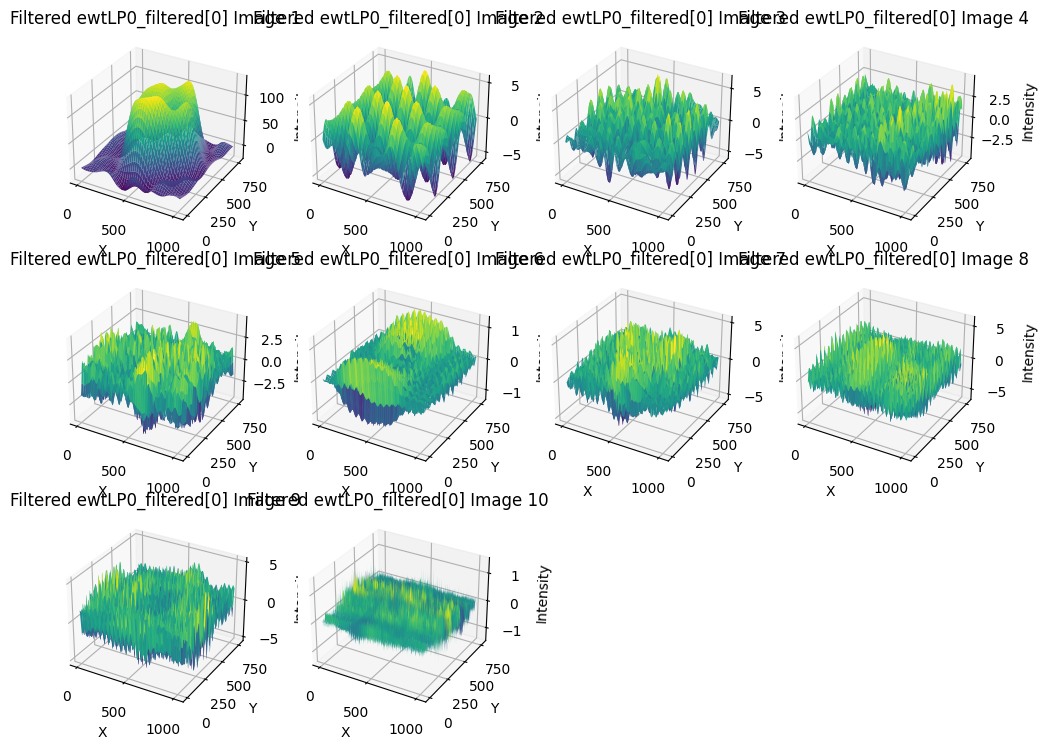

Statistical features for ewtLP0_filtered[0] filtered image 1:
mean: 34.77232820580859
std: 47.714767409943846
min: -24.220666853215018
max: 134.42709960840412
skewness: 0.7233725715317093
kurtosis: -1.1194125241498916
Statistical features for ewtLP0_filtered[0] filtered image 2:
mean: 2.4365381090878754e-17
std: 2.5344839745555734
min: -5.7427483394075995
max: 5.7427483394075995
skewness: 9.577323120688604e-17
kurtosis: -0.7882736449381684
Statistical features for ewtLP0_filtered[0] filtered image 3:
mean: 1.3396689225949718e-32
std: 2.0703629683103805e-15
min: -5.94925809176604e-15
max: 6.71151704840072e-15
skewness: -0.003624356822551153
kurtosis: -0.2983480225481099
Statistical features for ewtLP0_filtered[0] filtered image 4:
mean: -4.894944140250859e-33
std: 1.4231468698960913e-15
min: -4.952523727904692e-15
max: 4.760312419726383e-15
skewness: -0.0010622271440759404
kurtosis: -0.17281485059815616
Statistical features for ewtLP0_filtered[0] filtered image 5:
mean: -4.1220582233691

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the path to the single image
image_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_0/ISIC_0000002_masked.jpg"

# Read the image
image = cv2.imread(image_path)

# Convert image to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = grayscale_image.shape

# Perform ppfft
ppff = ppfft(grayscale_image)

# Calculate mean magnitude
mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

# Plot mean magnitude
plt.plot(mean_ppff)
plt.title("Mean Magnitude of ppfft")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Define points for filter bank
points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
num = np.asarray(points) * np.pi
points = num / np.round(len(mean_ppff) / 2)

# Apply EWT2D filter bank
mfb = ewt2d_LPFilterbank(points, h, w)

# Filter out coefficients
ff = np.fft.fft2(grayscale_image)
ewtLP = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

plt.figure()
plt.imshow(grayscale_image, cmap='gray')
plt.title(f"Grayscale image of Original")
plt.show()

# Display filtered images
plt.figure(figsize=(12, 12))
for m in range(len(mfb)):
    plt.subplot(4, 4, m+1)
    plt.imshow(ewtLP[m], cmap='gray')
    plt.title(f"Filtered Image {m+1}")
    plt.axis('off')
plt.show()

import matplotlib.pyplot as plt

# Display filtered images one by one in a new window
for m in range(len(ewtLP)):
    plt.figure()
    plt.imshow(ewtLP[m], cmap='gray')
    plt.title(f"Filtered Image {m+1}")
    plt.axis('off')
    plt.show()



# Display filtered images with surface plots
fig = plt.figure(figsize=(12, 12))
for m in range(len(mfb)):
    ax = fig.add_subplot(4, 4, m+1, projection='3d')

    # Generate X and Y coordinates
    x = np.arange(ewtLP[m].shape[1])
    y = np.arange(ewtLP[m].shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot surface
    ax.plot_surface(X, Y, ewtLP[m], cmap='viridis')

    ax.set_title(f"Filtered Image {m+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')

plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Display filtered images with surface plots one by one in a new window
for m in range(len(ewtLP)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Generate X and Y coordinates
    x = np.arange(ewtLP[m].shape[1])
    y = np.arange(ewtLP[m].shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot surface
    ax.plot_surface(X, Y, ewtLP[m], cmap='viridis')

    ax.set_title(f"Filtered Image {m+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')

    plt.show()



# Extract statistical features for the grayscale image
statistical_features_grayscale = extract_statistical_features(grayscale_image)
print("Statistical features for grayscale image:")
for key, value in statistical_features_grayscale.items():
    print(f"{key}: {value}")

# Extract statistical features for each EWT coefficient
statistical_features_ewtLP = []
for coeff in ewtLP:
    statistical_features_ewtLP.append(extract_statistical_features(coeff))

# Display statistical features for each EWT coefficient
for i, features in enumerate(statistical_features_ewtLP):
    print(f"\nStatistical features for EWT coefficient {i+1}:")
    for key, value in features.items():
        print(f"{key}: {value}")

# Compute and display the fractal dimension for the grayscale image
fractal_dimension_grayscale = fractal_dimension(grayscale_image)
print("Fractal dimension of grayscale image:", fractal_dimension_grayscale)

# Compute and display the fractal dimension for each EWT coefficient
fractal_dimensions_ewtLP = []
for i, coeff in enumerate(ewtLP):
    fractal_dimensions_ewtLP.append(fractal_dimension(coeff))
    print(f"Fractal dimension of EWT coefficient {i+1}: {fractal_dimensions_ewtLP[-1]}")

# Compute 2D Teager-Kaiser energy for the grayscale image
tk_energy = taeger_kaiser_energy_2d(grayscale_image)
print("2D Teager-Kaiser Energy of grayscale_image:", tk_energy)

# Calculate and print Teager-Kaiser energy value for each filtered image
for i, filtered_image in enumerate(ewtLP):
    tk_energy = taeger_kaiser_energy_2d(filtered_image)
    print(f"Teager-Kaiser energy value for filtered image {i+1}: {tk_energy}")

# Apply EWT2D filter bank to ewtLP[0]
ewtLP0_ff = np.fft.fft2(ewtLP[0])
ewtLP0_filtered = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))



# Display filtered images one by one in a new window
for m in range(len(ewtLP)):
    plt.figure()
    plt.imshow(ewtLP0_filtered[m], cmap='gray')
    plt.title(f"Filtered ewtLP[0] Image {m+1}")
    plt.axis('off')
    plt.show()





# Display filtered images with surface plots one by one in a new window
for m in range(len(ewtLP)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

  # Generate X and Y coordinates
    x = np.arange(ewtLP0_filtered[m].shape[1])
    y = np.arange(ewtLP0_filtered[m].shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot surface
    ax.plot_surface(X, Y, ewtLP0_filtered[m], cmap='viridis')

    ax.set_title(f"Filtered ewtLP[0] Image{m+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')

    plt.show()




# Extract statistical features for the filtered images of ewtLP[0]
for idx, filtered_img in enumerate(ewtLP0_filtered):
    statistical_features_filtered = extract_statistical_features(filtered_img)
    print(f"Statistical features for ewtLP[0] filtered image {idx+1}:")
    for key, value in statistical_features_filtered.items():
        print(f"{key}: {value}")

# Compute and display the fractal dimension for each EWT coefficient of ewtLP[0]
fractal_dimensions_ewtLP0 = []
for i, coeff in enumerate(ewtLP0_filtered):
    fractal_dimensions_ewtLP0.append(fractal_dimension(coeff))
    print(f"Fractal dimension of ewtLP[0] coefficient {i+1}: {fractal_dimensions_ewtLP0[-1]}")

# Compute 2D Teager-Kaiser energy for the first filtered image of ewtLP[0]
tk_energy = taeger_kaiser_energy_2d(ewtLP[0])
print("2D Teager-Kaiser Energy of ewtLP[0]:", tk_energy)

# Calculate and print Teager-Kaiser energy value for each filtered image of ewtLP[0]
for i, filtered_image in enumerate(ewtLP0_filtered):
    tk_energy = taeger_kaiser_energy_2d(filtered_image)
    print(f"Teager-Kaiser energy value for ewtLP[0] filtered image {i+1}: {tk_energy}")

# Apply EWT2D filter bank to ewtLP0_filtered[0]
ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
ewtLP0_filtered0_refiltered = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP0_filtered0_refiltered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

# Display filtered images of ewtLP0_filtered[0]
plt.figure(figsize=(12, 12))
for m in range(len(mfb)):
    plt.subplot(4, 4, m+1)
    plt.imshow(ewtLP0_filtered0_refiltered[m], cmap='gray')
    plt.title(f"Filtered ewtLP0_filtered[0] Image {m+1}")
    plt.axis('off')
plt.show()

# Display filtered images of ewtLP0_filtered[0] with surface plots
fig = plt.figure(figsize=(12, 12))
for m in range(len(mfb)):
    ax = fig.add_subplot(4, 4, m+1, projection='3d')

    # Generate X and Y coordinates
    x = np.arange(ewtLP0_filtered0_refiltered[m].shape[1])
    y = np.arange(ewtLP0_filtered0_refiltered[m].shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot surface
    ax.plot_surface(X, Y, ewtLP0_filtered0_refiltered[m], cmap='viridis')

    ax.set_title(f"Filtered ewtLP0_filtered[0] Image {m+1}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')

plt.show()

# Extract statistical features for the filtered images of ewtLP0_filtered[0]
for idx, filtered_img in enumerate(ewtLP0_filtered0_refiltered):
    statistical_features_filtered = extract_statistical_features(filtered_img)
    print(f"Statistical features for ewtLP0_filtered[0] filtered image {idx+1}:")
    for key, value in statistical_features_filtered.items():
        print(f"{key}: {value}")

# Compute and display the fractal dimension for each EWT coefficient of ewtLP0_filtered[0]
fractal_dimensions_ewtLP0_filtered0 = []
for i, coeff in enumerate(ewtLP0_filtered0_refiltered):
    fractal_dimensions_ewtLP0_filtered0.append(fractal_dimension(coeff))
    print(f"Fractal dimension of ewtLP0_filtered[0] coefficient {i+1}: {fractal_dimensions_ewtLP0_filtered0[-1]}")

# Compute 2D Teager-Kaiser energy for the first filtered image of ewtLP0_filtered[0]
tk_energy = taeger_kaiser_energy_2d(ewtLP0_filtered[0])
print("2D Teager-Kaiser Energy of ewtLP0_filtered[0]:", tk_energy)

# Calculate and print Teager-Kaiser energy value for each filtered image of ewtLP0_filtered[0]
for i, filtered_image in enumerate(ewtLP0_filtered0_refiltered):
    tk_energy = taeger_kaiser_energy_2d(filtered_image)
    print(f"Teager-Kaiser energy value for ewtLP0_filtered[0] filtered image {i+1}: {tk_energy}")


Mounted at /content/drive


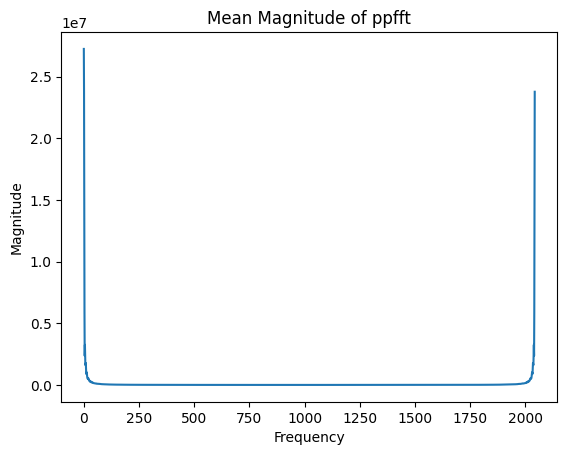

Statistical features for Filtered Image 1:
Mean: 34.77232820580859
StdDev: 47.89246605450138
Skewness: 0.7161991939551327
Kurtosis: -1.1321784960736716
Statistical features for Filtered Image 2:
Mean: 5.917306836356269e-17
StdDev: 15.057116873338122
Skewness: 0.04769080843273002
Kurtosis: 0.27795872776017205
Statistical features for Filtered Image 3:
Mean: -1.044230618180518e-17
StdDev: 9.362124621074834
Skewness: 0.018874688637422553
Kurtosis: -0.09928426136041457
Statistical features for Filtered Image 4:
Mean: 3.0166662302992745e-17
StdDev: 8.366143536742396
Skewness: 0.08367053790732656
Kurtosis: 0.41608112342068404
Statistical features for Filtered Image 5:
Mean: -3.0166662302992745e-17
StdDev: 6.686506410377041
Skewness: 0.0031194415102924807
Kurtosis: 0.5585447034483
Statistical features for Filtered Image 6:
Mean: 1.2182690545439377e-17
StdDev: 5.872827211555363
Skewness: -0.05957510677743859
Kurtosis: 0.8762914141796512
Statistical features for Filtered Image 7:
Mean: -1.56634

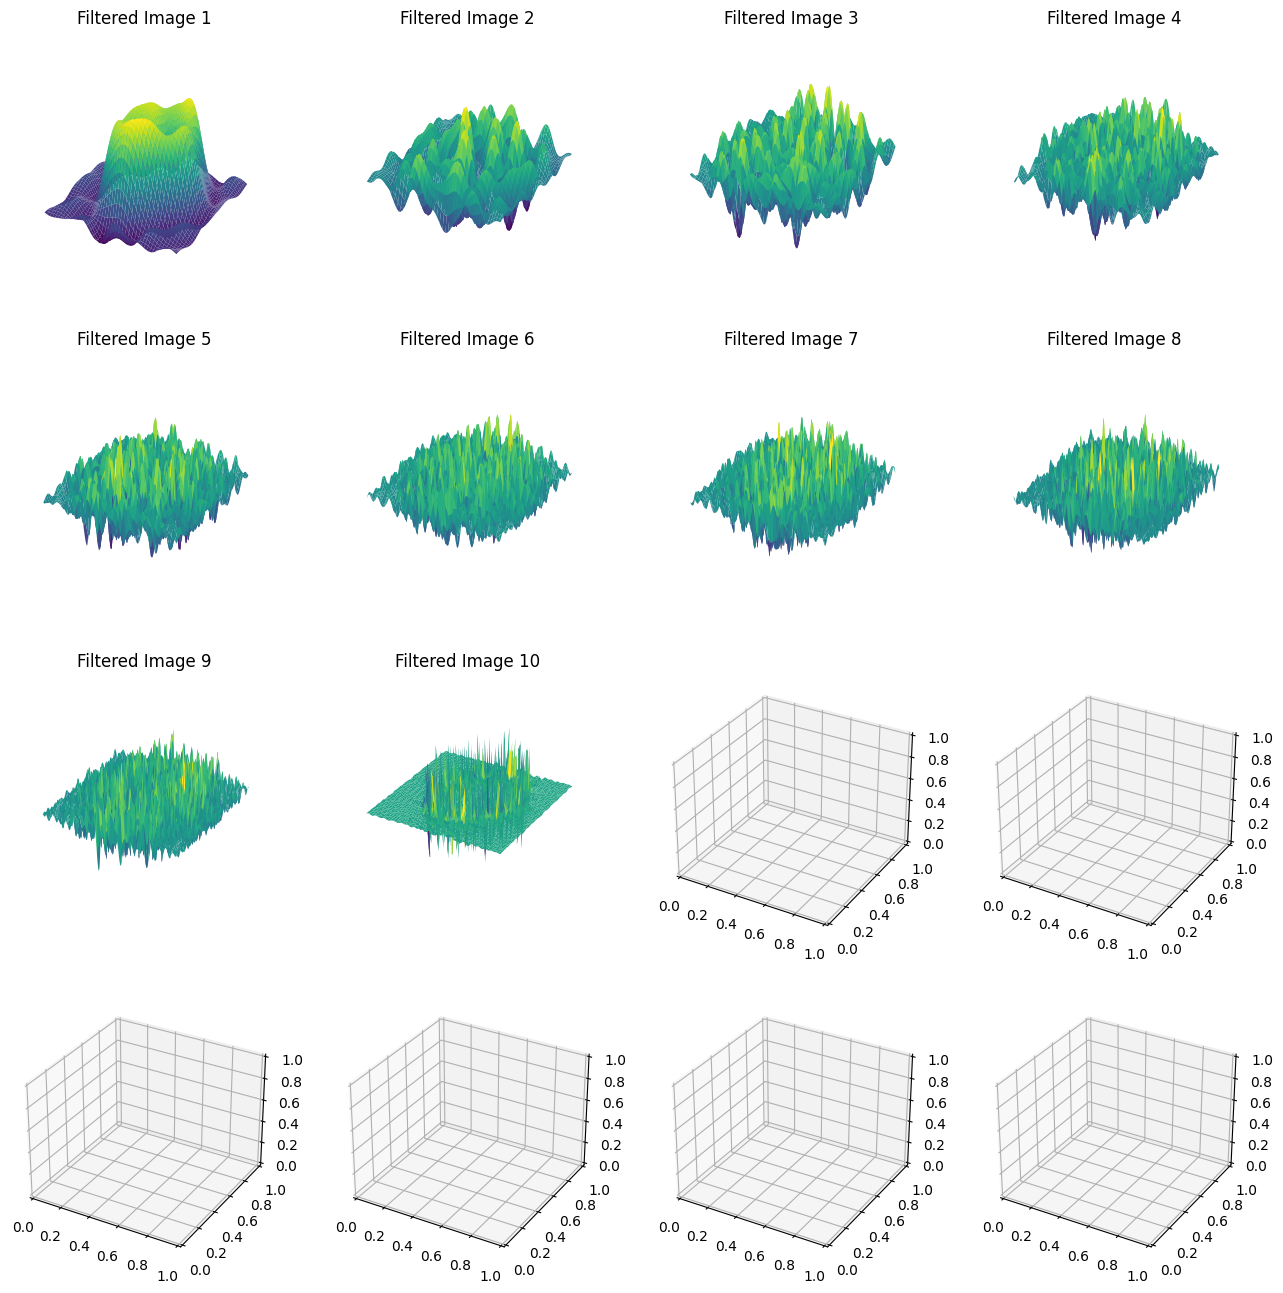

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from google.colab.patches import cv2_imshow

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

def ppfft(f):
    # f is assumed N x N where N is even. If not, we just force it to be
    [h, w] = f.shape
    N = h
    f2 = f
    if h != w or np.mod(h, 2) == 1:
        N = int(np.ceil(max(h, w) / 2) * 2) # N is biggest dimension, but force even
        f2 = np.zeros([N, N])
        f2[N // 2 - int(h / 2):N // 2 - int(h / 2) + h, N // 2 - int(w / 2):N // 2 - int(w / 2) + w] = f
    ppff = np.zeros([2 * N, 2 * N]) * 1j

    # Constructing Quadrants 1 and 3
    ff = np.fft.fft(f2, N * 2, axis=0)
    ff = np.fft.fftshift(ff, 0)
    for i in range(-N, N):
        ppff[i + N, N - 1::-1] = fracfft(ff[i + N, :], i / (N ** 2), 1)

    # Constructing quadrants 2 and 4
    ff = np.fft.fft(f2, N * 2, axis=1)
    ff = np.fft.fftshift(ff, 1)
    ff = ff.T

    for i in range(-N, N):
        x = np.arange(0, N)
        factor = np.exp(1j * 2 * np.pi * x * (N / 2 - 1) * i / (N ** 2))
        ppff[i + N, N:2 * N] = fracfft(ff[i + N, :] * factor, i / (N ** 2))
    return ppff

def fracfft(f, alpha, centered=0):
    f = np.reshape(f.T, f.size)  # flatten f
    N = len(f)  # get length

    if centered == 1:
        x = np.arange(0, N)
        factor = np.exp(1j * np.pi * x * N * alpha)
        f = f * factor

    x = np.append(np.arange(0, N), np.arange(-N, 0))
    factor = np.exp(-1j * np.pi * alpha * x ** 2)
    ff = np.append(f, np.zeros(N))
    ff = ff * factor
    XX = np.fft.fft(ff)
    YY = np.fft.fft(np.conj(factor))

    result = np.fft.ifft(XX * YY)
    result = result * factor
    result = result[0:N]
    return result

def extract_statistical_features(image):
    # Calculate statistical features from the image
    features = {}
    features['Mean'] = np.mean(image)
    features['StdDev'] = np.std(image)
    features['Skewness'] = skew(image.flatten())
    features['Kurtosis'] = kurtosis(image.flatten())
    return features

def ewt2d_LPscaling(radii, bound0, gamma):
    an = 1 / (2 * gamma * bound0)
    mbn = (1 - gamma) * bound0 # inner circle up to beginning of transtion
    pbn = (1 + gamma) * bound0 # end of transition

    scaling = 0 * radii # initiate w/ zeros
    scaling[radii < mbn] = 1
    scaling[radii >= mbn] = np.cos(np.pi * ewt_beta(an * (radii[radii >= mbn] - mbn)) / 2)
    scaling[radii > pbn] = 0
    return scaling

def ewt2d_LPwavelet(radii, bound1, bound2, gamma):
    wan = 1 / (2 * gamma * bound1) # scaling factor
    wam = 1 / (2 * gamma * bound2)
    wmbn = (1 - gamma) * bound1 # beginning of lower transition
    wpbn = (1 + gamma) * bound1 # end of lower transition
    wmbm = (1 - gamma) * bound2  # beginning of upper transition
    wpbm = (1 + gamma) * bound2 # end of upper transition

    wavelet = 0 * radii # initialize w/ zeros
    inside = (radii > wmbn) * (radii < wpbm)
    wavelet[inside] = 1.0 # set entire angular wedge equal to 1
    temp = inside * (radii >= wmbm) * (radii <= wpbm) # upper transition
    wavelet[temp] *= np.cos(np.pi * ewt_beta(wam * (radii[temp] - wmbm)) / 2)
    temp = inside * (radii >= wmbn) * (radii <= wpbn) # lower transition
    wavelet[temp] *= np.sin(np.pi * ewt_beta(wan * (radii[temp] - wmbn)) / 2)
    return wavelet

def ewt_beta(x):
    bm = (x >= 0) * (x <= 1) \
        * (x ** 4 * (35 - 84 * x + 70 * x ** 2 - 20 * x ** 3))
    bm += (x > 1)
    return bm

def ewt2d_LPFilterbank(bounds_scales, h, w):
    if h % 2 == 0:
        h += 1
        h_extended = 1
    else:
        h_extended = 0
    if w % 2 == 0:
        w += 1
        w_extended = 1
    else:
        w_extended = 0

    gamma_scales = np.pi
    for k in range(len(bounds_scales) - 1):
        r = (bounds_scales[k + 1] - bounds_scales[k]) / (bounds_scales[k + 1] + bounds_scales[k])
        if r < gamma_scales and r > 1e-16:
            gamma_scales = r
    r = (np.pi - bounds_scales[-1]) / (np.pi + bounds_scales[-1]) # check last bound
    if r < gamma_scales and r > 1e-16:
        gamma_scales = r
    if gamma_scales > bounds_scales[0]: # check first bound
        gamma_scales = bounds_scales[0]
    gamma_scales *= (1 - 1 / max(h, w)) # guarantees that we have strict inequality

    radii = np.zeros([h, w])
    h_center = h // 2 + 1
    w_center = w // 2 + 1
    for i in range(h):
        for j in range(w):
            ri = (i + 1.0 - h_center) * np.pi / h_center
            rj = (j + 1.0 - w_center) * np.pi / w_center
            radii[i, j] = np.sqrt(ri ** 2 + rj ** 2)

    mfb = []
    mfb.append(ewt2d_LPscaling(radii, bounds_scales[0], gamma_scales))
    for i in range(len(bounds_scales) - 1):
        mfb.append(ewt2d_LPwavelet(radii, bounds_scales[i], bounds_scales[i + 1], gamma_scales))
    mfb.append(ewt2d_LPwavelet(radii, bounds_scales[-1], 2 * np.pi, gamma_scales))

    if h_extended == 1: # if we extended the height of the image, trim
        h -= 1
        for i in range(len(mfb)):
            mfb[i] = mfb[i][0:-1, :]
    if w_extended == 1: # if we extended the width of the image, trim
        w -= 1
        for i in range(len(mfb)):
            mfb[i] = mfb[i][:, 0:-1]

    # Invert the fftshift since filters are centered
    for i in range(len(mfb)):
        mfb[i] = np.fft.ifftshift(mfb[i])

    # Resymmetrize for even images
    if h_extended == 1:
        s = np.zeros(w)
        if w % 2 == 0:
            mfb[-1][h // 2, 1:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2 - 1:0:-1]
            s += mfb[-1][h // 2, :] ** 2
            # Normalize for tight frame
            mfb[-1][h // 2, 1:w // 2] /= np.sqrt(s[1:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
        else:
            mfb[-1][h // 2, 0:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2 - 1::-1]
            s += mfb[-1][h // 2, :] ** 2
            # Normalize for tight frame
            mfb[-1][h // 2, 0:w // 2] /= np.sqrt(s[0:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
    if w_extended == 1:
        s = np.zeros(h)
        if h % 2 == 0:
            mfb[-1][1:h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1:0:-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            # Normalize for tight frame
            mfb[-1][1:h // 2, w // 2] /= np.sqrt(s[1:h // 2])
            mfb[-1][h // 2 + 1:, w // 2] /= np.sqrt(s[h // 2 + 1:])
        else:
            mfb[-1][0:h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1::-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            # Normalize for tight frame
            mfb[-1][0:h // 2, w // 2] /= np.sqrt(s[0:h // 2])
            mfb[-1][h // 2 + 1:, w // 2] /= np.sqrt(s[h // 2 + 1:])
    return mfb

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_0"
image_file = "ISIC_0000002_masked.jpg"

# Construct the full path to the image
image_path = os.path.join(dataset_dir, image_file)

# Read the image
image = cv2.imread(image_path)

# Convert image to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = grayscale_image.shape

# Perform ppfft
ppff = ppfft(grayscale_image)

# Calculate mean magnitude
mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

# Plot mean magnitude
plt.plot(mean_ppff)
plt.title("Mean Magnitude of ppfft")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Define points for filter bank
points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
num = np.asarray(points) * np.pi
points = num / np.round(len(mean_ppff) / 2)

# Apply EWT2D filter bank
mfb = ewt2d_LPFilterbank(points, h, w)

# Filter out coefficients
ff = np.fft.fft2(grayscale_image)
ewtLP = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

# Display filtered images, extract statistical features, and plot 3D surface
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for m in range(len(mfb)):
    ax = axes[m]
    X, Y = np.meshgrid(range(ewtLP[m].shape[1]), range(ewtLP[m].shape[0]))
    ax.plot_surface(X, Y, ewtLP[m], cmap='viridis')
    ax.set_title(f"Filtered Image {m+1}")
    ax.axis('off')

    # Extract statistical features from filtered image
    features = extract_statistical_features(ewtLP[m])
    print(f"Statistical features for Filtered Image {m+1}:")
    for feature, value in features.items():
        print(f"{feature}: {value}")

plt.show()


In [ ]:
############              saving Data for Maliognant 2017 0-103


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/2017_train_0/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:103]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.jpg') or image_file.endswith('.bmp'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)
###############################################################
        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy
#################################################
        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

##############################################################################
          # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered_3rd = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered_3rd[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

         # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered_3rd):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_3rd_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered_3rd):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_3rd_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_3rd_{i+1}_tk_energy'] = tk_energy


        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 0


# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/2017_0_masked_statistical_features.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Mounted at /content/drive


In [ ]:
############              saving Data for Maliognant


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_0/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:171]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 0



# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_0.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_0.xlsx


In [ ]:
############              saving Data for Maliognant


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_0/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:171]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered_3rd = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered_3rd[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

         # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered_3rd):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_3rd_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered_3rd):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_3rd_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_3rd_{i+1}_tk_energy'] = tk_energy


        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 0



# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_0_3rd.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Mounted at /content/drive
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_0_3rd.xlsx


In [ ]:
############              saving Data for Test Maliognant


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Test/0/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:73]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

         # Apply EWT2D filter bank to ewtLP[0]_3rd
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered_3rd = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered_3rd[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

         # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered_3rd):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_3rd_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered_3rd):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_3rd_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_3rd_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 0



# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_0.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_0.xlsx


In [ ]:
############              saving Data for Test non Maliognant 1


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Test/1/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:106]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

         # Apply EWT2D filter bank to ewtLP[0]_3rd
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered_3rd = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered_3rd[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

         # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered_3rd):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_3rd_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered_3rd):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_3rd_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_3rd_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 1



# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_1.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_1.xlsx


In [ ]:
############              saving Data for Test non Maliognant 2


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Test/2/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:106]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

         # Apply EWT2D filter bank to ewtLP[0]_3rd
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered_3rd = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered_3rd[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

         # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered_3rd):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_3rd_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered_3rd):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_3rd_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_3rd_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 1



# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_2.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_2.xlsx


In [ ]:
############              saving Data for Test non Maliognant 3


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Test/3/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:106]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

         # Apply EWT2D filter bank to ewtLP[0]_3rd
        ewtLP0_filtered0_ff = np.fft.fft2(ewtLP0_filtered[0])
        ewtLP0_filtered_3rd = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered_3rd[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_filtered0_ff))

         # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered_3rd):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_3rd_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered_3rd):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_3rd_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_3rd_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 0 for malignant
df['label'] = 1



# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_3.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_Test_3.xlsx


In [ ]:
############              saving Data for NON-Maliognant 2


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/3/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:729]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_1.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_1.xlsx


In [ ]:
############              saving Data for NON-Maliognant 2


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/2/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:729]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_2.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_2.xlsx


In [ ]:
############              saving Data for NON-Maliognant 3


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/3/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:729]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_3.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_3.xlsx


In [ ]:
############              saving Data for NON-Maliognant 4


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/4/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:100]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_4.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All features saved to /content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_4.xlsx


In [ ]:
############              saving Data for NON-Maliognant 5


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/5/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:100]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_5.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


MessageError: Error: credential propagation was unsuccessful

In [ ]:
############              saving Data for NON-Maliognant 6


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/6/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:100]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_6.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


In [ ]:
############              saving Data for NON-Maliognant 7


import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/data_Set/Masked_1/7/"

# List all files in the dataset directory
image_files = os.listdir(dataset_dir)

# Select the first 10 image files
image_files = image_files[:129]


# List to store all features
all_features_list = []

# Loop over each image file
for image_file in image_files:
    # Check if the file is an image
    if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
        # Construct the full path to the image
        image_path = os.path.join(dataset_dir, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = grayscale_image.shape

        # Initialize a dictionary to store features
        features = {
            'image_name': image_file
        }

        # Extract and store statistical features, fractal and TKE for the grayscale image
        statistical_features_grayscale = extract_statistical_features(grayscale_image)
        for key, value in statistical_features_grayscale.items():
            fractal_dim = fractal_dimension(grayscale_image)
            tk_energy = taeger_kaiser_energy_2d(grayscale_image)
            features[f'grayscale_image_fractal_dim'] = fractal_dim
            features[f'grayscale_image_tk_energy'] = tk_energy
            features[f'grayscale_{key}'] = value

        # Perform ppfft
        ppff = ppfft(grayscale_image)

        # Calculate mean magnitude
        mean_ppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))

        # Define points for filter bank
        points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        num = np.asarray(points) * np.pi
        points = num / np.round(len(mean_ppff) / 2)

        # Apply EWT2D filter bank
        mfb = ewt2d_LPFilterbank(points, h, w)

        # Filter out coefficients
        ff = np.fft.fft2(grayscale_image)
        ewtLP = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

        # Extract and store fractal dimension and Teager-Kaiser energy for each EWT coefficient
        for i, coeff in enumerate(ewtLP):
            stat_features = extract_statistical_features(coeff)
            for key, value in stat_features.items():
                features[f'ewtLP_{i+1}_{key}'] = value

            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP_{i+1}_tk_energy'] = tk_energy

        # Apply EWT2D filter bank to ewtLP[0]
        ewtLP0_ff = np.fft.fft2(ewtLP[0])
        ewtLP0_filtered = [None] * len(mfb)
        for k in range(len(mfb)):
            ewtLP0_filtered[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ewtLP0_ff))

        # Extract and store statistical features for the filtered images of ewtLP[0]
        for idx, filtered_img in enumerate(ewtLP0_filtered):
            statistical_features_filtered = extract_statistical_features(filtered_img)
            for key, value in statistical_features_filtered.items():
                features[f'ewtLP0_filtered_{idx+1}_{key}'] = value

        # Extract and store fractal dimension and Teager-Kaiser energy for each filtered image of ewtLP[0]
        for i, coeff in enumerate(ewtLP0_filtered):
            fractal_dim = fractal_dimension(coeff)
            tk_energy = taeger_kaiser_energy_2d(coeff)
            features[f'ewtLP0_filtered_{i+1}_fractal_dim'] = fractal_dim
            features[f'ewtLP0_filtered_{i+1}_tk_energy'] = tk_energy

        # Append features dictionary to list
        all_features_list.append(features)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features_list)

# Add a column for the label, set to 1 for NON malignant
df['label'] = 1

# Save the DataFrame to an Excel file
excel_path = "/content/drive/MyDrive/Colab Notebooks/data_Set/statistical_features_all_images_7.xlsx"
df.to_excel(excel_path, index=False)

print(f"All features saved to {excel_path}")


In [ ]:
pip install pandas scikit-learn openpyxl


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features_Final.xlsx'
df = pd.read_excel(file_path)

# Drop the non-numeric columns (e.g., filenames)
df = df.drop(columns=['image_name'])  # Replace 'image_name' with the actual column name if it's different

# Ensure the features are numeric
X = df.iloc[:, :-1]  # Features
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Re-define X and y after dropping NaN values
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

# Check the unique classes in the labels
initial_classes = y.unique()
print(f'Initial unique classes: {initial_classes}')
if len(initial_classes) <= 1:
    raise ValueError(f"The initial dataset must contain at least two classes. Found classes: {initial_classes}")

# Check the unique classes after dropping NaNs
cleaned_classes = y.unique()
print(f'Unique classes after cleaning: {cleaned_classes}')
if len(cleaned_classes) <= 1:
    raise ValueError(f"The cleaned dataset must contain at least two classes. Found classes: {cleaned_classes}")

# Split the data into training and testing sets, ensuring stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify that both training and testing sets have more than one class
train_classes = y_train.unique()
test_classes = y_test.unique()
print(f'Training set classes: {train_classes}')
print(f'Test set classes: {test_classes}')
if len(train_classes) <= 1 or len(test_classes) <= 1:
    raise ValueError(f"Both training and testing sets must each contain at least two classes. Found classes in training set: {train_classes}, test set: {test_classes}")

# Initialize the AdaBoost classifier
ada_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the classifier
ada_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ada_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial unique classes: [0 1]
Unique classes after cleaning: [0 1]
Training set classes: [1 0]
Test set classes: [0 1]
Accuracy: 0.7611111111111111
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.15      0.19        34
           1       0.82      0.90      0.86       146

    accuracy                           0.76       180
   macro avg       0.54      0.53      0.52       180
weighted avg       0.71      0.76      0.73       180



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features_Final.xlsx'
df = pd.read_excel(file_path)

# Drop the non-numeric columns (e.g., filenames)
df = df.drop(columns=['image_name'])  # Replace 'filename' with the actual column name if it's different

# Assuming the last column is the label
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

# Ensure the features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (optional, based on your data)
df = df.dropna()

# Re-split the data after cleaning (optional, based on your data cleaning step)
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Mounted at /content/drive


In [ ]:
pip install hpelm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import hpelm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features_Final.xlsx'
df = pd.read_excel(file_path)

# Drop the non-numeric columns (e.g., filenames)
df = df.drop(columns=['image_name'])  # Replace 'image_name' with the actual column name if it's different

# Ensure the features are numeric
X = df.iloc[:, :-1]  # Features
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Re-define X and y after dropping NaN values
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

# Check the unique classes in the labels
unique_classes = y.unique()
print(f'Initial unique classes: {unique_classes}')
if len(unique_classes) <= 1:
    raise ValueError(f"The initial dataset must contain at least two classes. Found classes: {unique_classes}")

# Split the data into training and testing sets, ensuring stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify that both training and testing sets have more than one class
train_classes = y_train.unique()
test_classes = y_test.unique()
print(f'Training set classes: {train_classes}')
print(f'Test set classes: {test_classes}')
if len(train_classes) <= 1 or len(test_classes) <= 1:
    raise ValueError(f"Both training and testing sets must each contain at least two classes. Found classes in training set: {train_classes}, test set: {test_classes}")

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to integers
y_train = y_train.astype(int).values
y_test = y_test.astype(int).values

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test.reshape(-1, 1))

# Initialize and train the ELM
input_dim = X_train.shape[1]
output_dim = len(unique_classes)
elm = hpelm.ELM(input_dim, output_dim, classification="c", batch=256)
elm.add_neurons(1000, "sigm")  # Add 1000 sigmoid neurons

# Train the classifier
elm.train(X_train, y_train_onehot, 'c')

# Make predictions on the test set
y_pred = elm.predict(X_test)

# Convert predicted values to class labels
y_pred_labels = y_pred.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial unique classes: [0 1]
Training set classes: [1 0]
Test set classes: [0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/usr/local/lib/python3.10/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


Accuracy: 0.6888888888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.32      0.28        34
           1       0.83      0.77      0.80       146

    accuracy                           0.69       180
   macro avg       0.54      0.55      0.54       180
weighted avg       0.72      0.69      0.70       180



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import hpelm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features_Final.xlsx'
df = pd.read_excel(file_path)

# Drop the non-numeric columns (e.g., filenames)
df = df.drop(columns=['image_name'])  # Replace 'image_name' with the actual column name if it's different

# Ensure the features are numeric
X = df.iloc[:, :-1]  # Features
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Re-define X and y after dropping NaN values
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

# Check the unique classes in the labels
unique_classes = y.unique()
print(f'Initial unique classes: {unique_classes}')
if len(unique_classes) <= 1:
    raise ValueError(f"The initial dataset must contain at least two classes. Found classes: {unique_classes}")

# Ensure the dataset has 900 samples (if not, use df.sample(900) to select 900 samples randomly)
if len(df) != 900:
    df = df.sample(900, random_state=42)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

# Split the data into training and testing sets (80% training, 20% testing), ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify that both training and testing sets have more than one class
train_classes = y_train.unique()
test_classes = y_test.unique()
print(f'Training set classes: {train_classes}')
print(f'Test set classes: {test_classes}')
if len(train_classes) <= 1 or len(test_classes) <= 1:
    raise ValueError(f"Both training and testing sets must each contain at least two classes. Found classes in training set: {train_classes}, test set: {test_classes}")

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to integers
y_train = y_train.astype(int).values
y_test = y_test.astype(int).values

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test.reshape(-1, 1))

# Initialize and train the ELM
input_dim = X_train.shape[1]
output_dim = len(unique_classes)
elm = hpelm.ELM(input_dim, output_dim, classification="c", batch=256)
elm.add_neurons(1000, "sigm")  # Add 1000 sigmoid neurons

# Train the classifier
elm.train(X_train, y_train_onehot, 'c')

# Make predictions on the test set
y_pred = elm.predict(X_test)

# Convert predicted values to class labels
y_pred_labels = y_pred.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial unique classes: [1 0]
Training set classes: [1 0]
Test set classes: [0 1]
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


Accuracy: 0.6722222222222223
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.47      0.35        34
           1       0.85      0.72      0.78       146

    accuracy                           0.67       180
   macro avg       0.57      0.59      0.57       180
weighted avg       0.75      0.67      0.70       180



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import hpelm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features_Final.xlsx'
df = pd.read_excel(file_path)

# Drop the non-numeric columns (e.g., filenames)
df = df.drop(columns=['image_name'])  # Replace 'image_name' with the actual column name if it's different

# Ensure the features are numeric
X = df.iloc[:, :-1]  # Features
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Re-define X and y after dropping NaN values
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels

# Check the unique classes in the labels
unique_classes = y.unique()
print(f'Initial unique classes: {unique_classes}')
if len(unique_classes) <= 1:
    raise ValueError(f"The initial dataset must contain at least two classes. Found classes: {unique_classes}")

# Ensure the dataset has 900 samples (if not, use df.sample(900) to select 900 samples randomly)
if len(df) != 900:
    df = df.sample(900, random_state=42)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

# Split the data into training and testing sets (80% training, 20% testing), ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify that both training and testing sets have more than one class
train_classes = y_train.unique()
test_classes = y_test.unique()
print(f'Training set classes: {train_classes}')
print(f'Test set classes: {test_classes}')
if len(train_classes) <= 1 or len(test_classes) <= 1:
    raise ValueError(f"Both training and testing sets must each contain at least two classes. Found classes in training set: {train_classes}, test set: {test_classes}")

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to integers
y_train = y_train.astype(int).values
y_test = y_test.astype(int).values

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test.reshape(-1, 1))

# Initialize and train the ELM
input_dim = X_train.shape[1]
output_dim = len(unique_classes)
elm = hpelm.ELM(input_dim, output_dim, classification="c", batch=256)
elm.add_neurons(1000, "sigm")  # Add 1000 sigmoid neurons

# Train the classifier
elm.train(X_train, y_train_onehot, 'c')

# Make predictions on the test set
y_pred = elm.predict(X_test)

# Convert predicted values to class labels
y_pred_labels = y_pred.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial unique classes: [1 0]
Training set classes: [1 0]
Test set classes: [0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/usr/local/lib/python3.10/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


Accuracy: 0.6833333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.44      0.34        34
           1       0.85      0.74      0.79       146

    accuracy                           0.68       180
   macro avg       0.57      0.59      0.57       180
weighted avg       0.74      0.68      0.71       180

Confusion Matrix:
[[ 15  19]
 [ 38 108]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)



import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
svm = SVC(kernel='rbf', probability=True)
# For ELM, assuming an implementation is available
# elm = ELMClassifier()  # Uncomment and define if ELM implementation is available
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn)]
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{name} Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"{name} Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='macro')}")

# Optionally, combine models into a voting classifier
voting_clf = VotingClassifier(estimators=models, voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(f"Voting Classifier Accuracy: {accuracy_score(y_test, y_pred)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 2296)
Labels shape: (1279,)
SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0
AdaBoost Accuracy: 1.0
AdaBoost Precision: 1.0
AdaBoost Recall: 1.0
AdaBoost F1 Score: 1.0
RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0
KNN Accuracy: 1.0
KNN Precision: 1.0
KNN Recall: 1.0
KNN F1 Score: 1.0
Voting Classifier Accuracy: 1.0


SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0


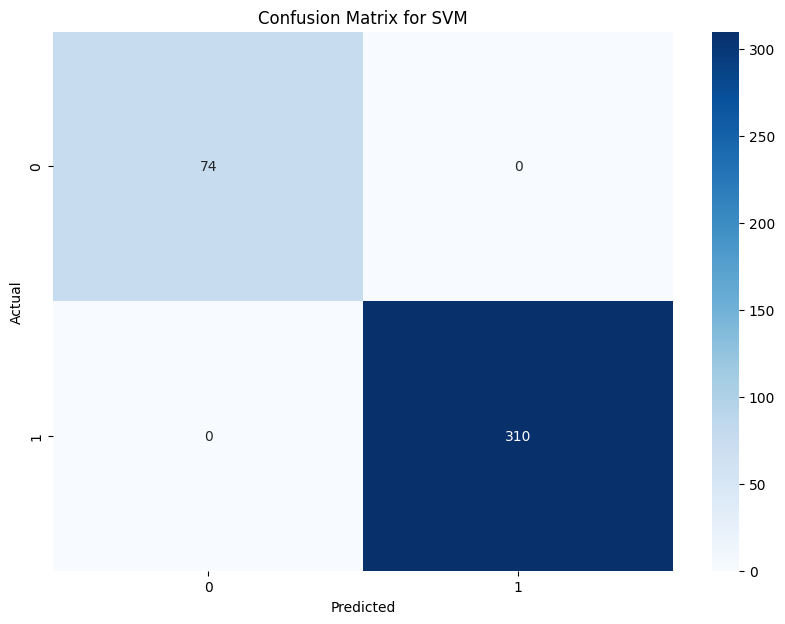

AdaBoost Accuracy: 1.0
AdaBoost Precision: 1.0
AdaBoost Recall: 1.0
AdaBoost F1 Score: 1.0


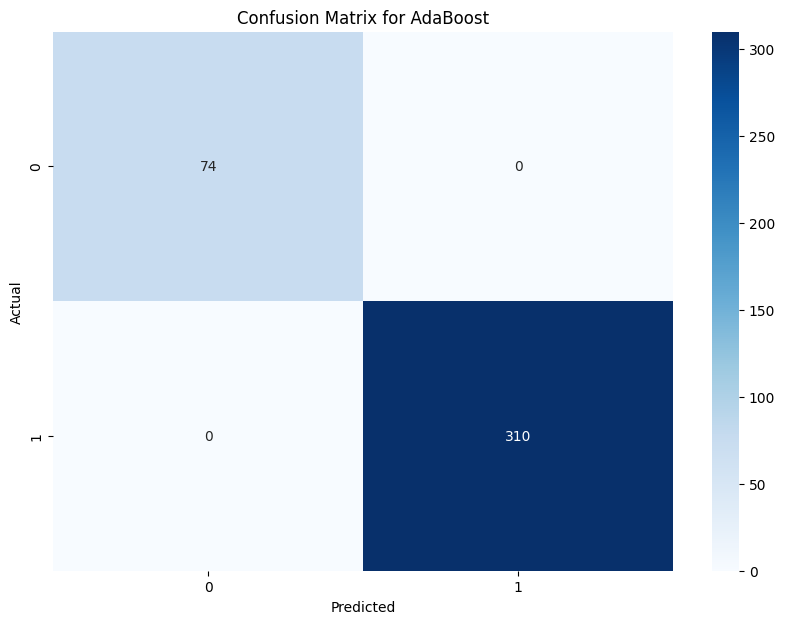

RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0


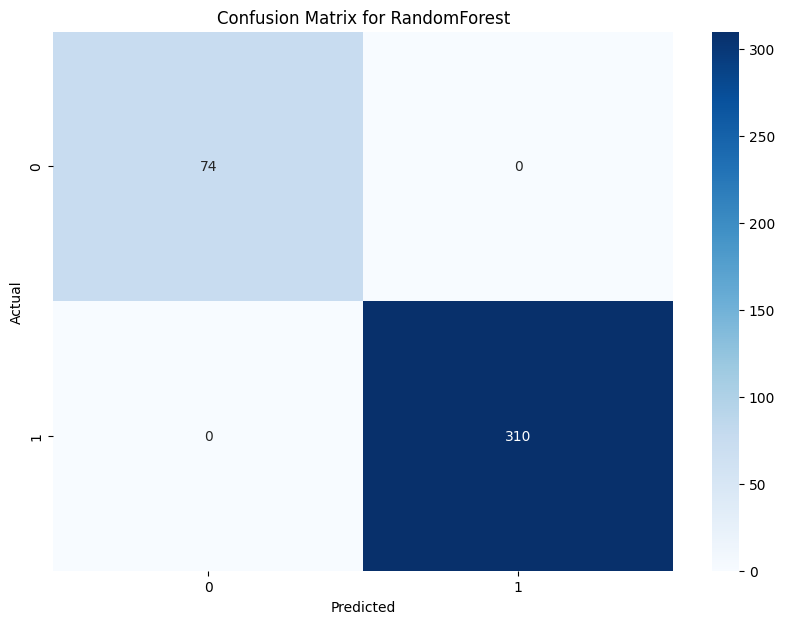

KNN Accuracy: 1.0
KNN Precision: 1.0
KNN Recall: 1.0
KNN F1 Score: 1.0


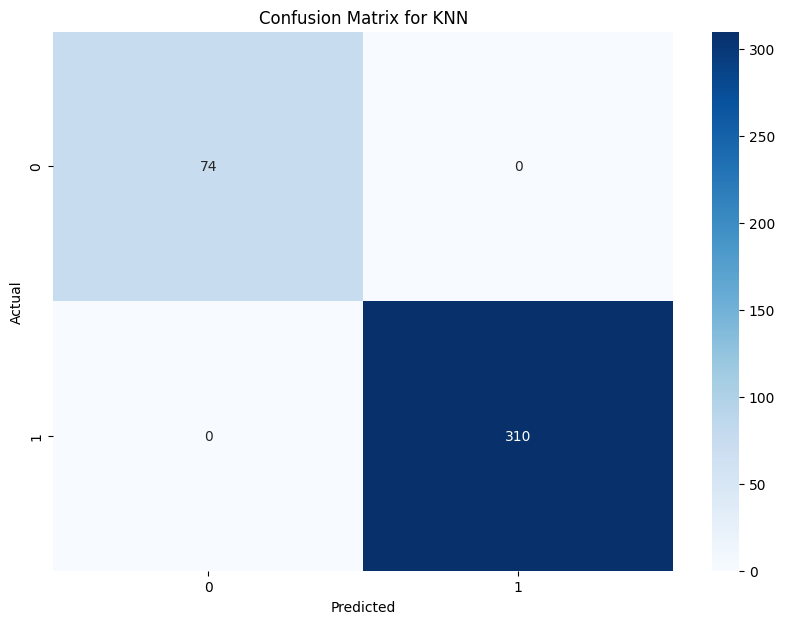

Voting Classifier Accuracy: 1.0


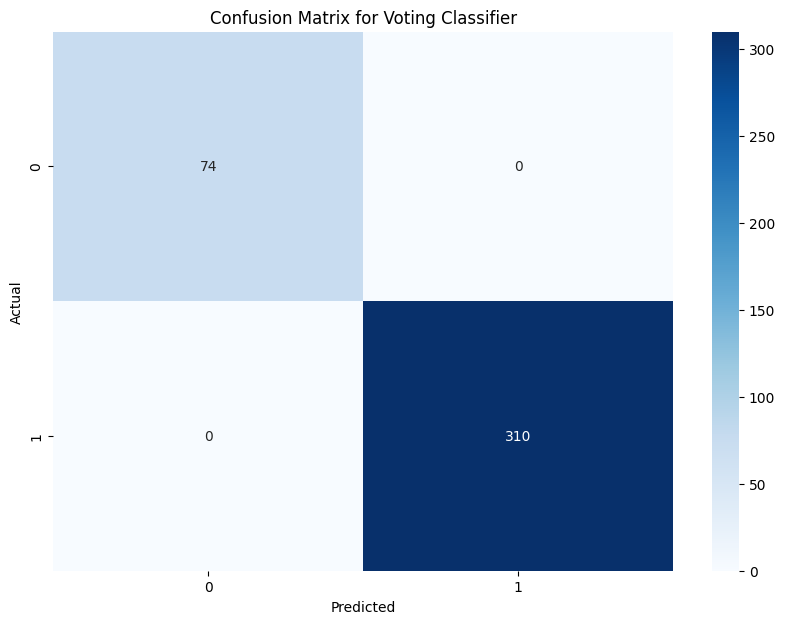

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
svm = SVC(kernel='rbf', probability=True)
# For ELM, assuming an implementation is available
# elm = ELMClassifier()  # Uncomment and define if ELM implementation is available
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn)]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{name} Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"{name} Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='macro')}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier
voting_clf = VotingClassifier(estimators=models, voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(f"Voting Classifier Accuracy: {accuracy_score(y_test, y_pred)}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
!pip install hpelm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.7 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 248)
Labels shape: (1279,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 0.8098958333333334
SVM Precision: 0.7388451443569554
SVM Recall: 0.5119006102877071
SVM F1 Score: 0.4731520288683819
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.03      0.05        74
           1       0.81      1.00      0.89       310

    accuracy                           0.81       384
   macro avg       0.74      0.51      0.47       384
weighted avg       0.78      0.81      0.73       384



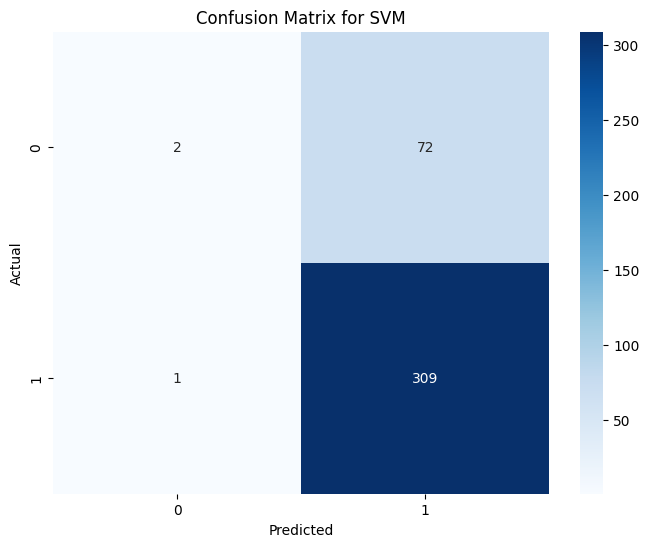

AdaBoost Accuracy: 0.7708333333333334
AdaBoost Precision: 0.5836898395721924
AdaBoost Recall: 0.5545771578029642
AdaBoost F1 Score: 0.5594263363754889
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.20      0.25        74
           1       0.83      0.91      0.86       310

    accuracy                           0.77       384
   macro avg       0.58      0.55      0.56       384
weighted avg       0.73      0.77      0.75       384



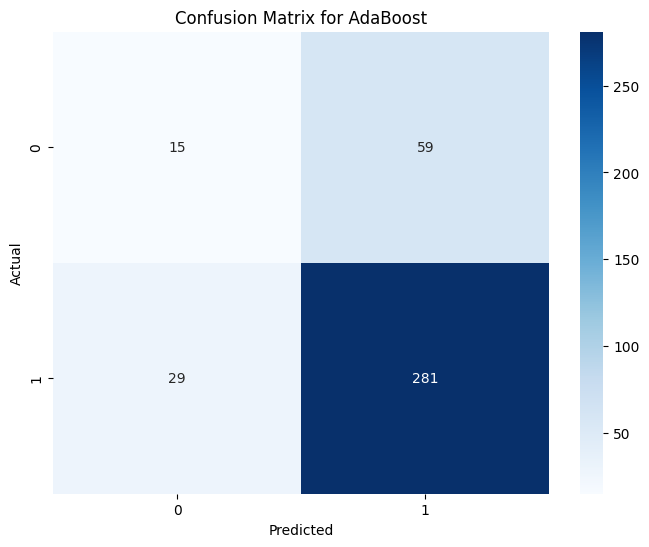

RandomForest Accuracy: 0.796875
RandomForest Precision: 0.48677248677248675
RandomForest Recall: 0.4986922406277245
RandomForest F1 Score: 0.4558139534883721
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.01      0.03        74
           1       0.81      0.98      0.89       310

    accuracy                           0.80       384
   macro avg       0.49      0.50      0.46       384
weighted avg       0.68      0.80      0.72       384



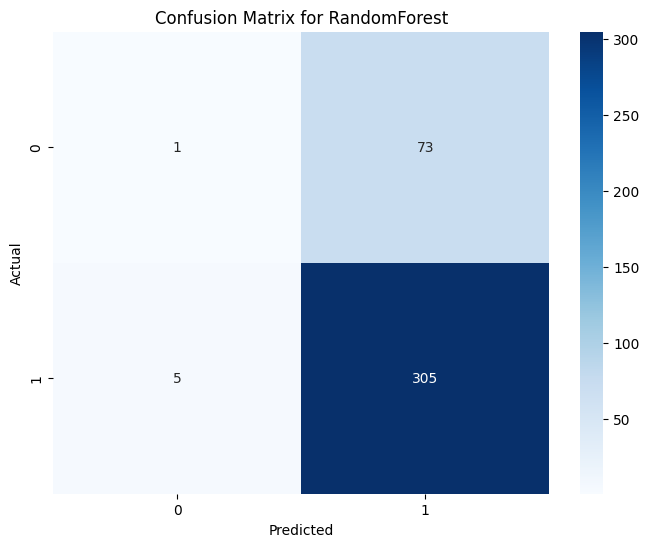

KNN Accuracy: 0.7942708333333334
KNN Precision: 0.6232751530658869
KNN Recall: 0.5588055797733217
KNN F1 Score: 0.5642318465847878
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.18      0.25        74
           1       0.83      0.94      0.88       310

    accuracy                           0.79       384
   macro avg       0.62      0.56      0.56       384
weighted avg       0.75      0.79      0.76       384



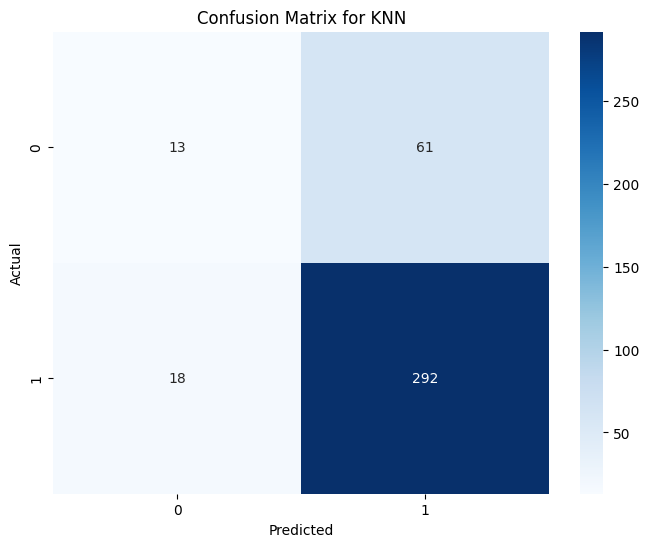

ELM Accuracy: 0.8072916666666666
ELM Precision: 0.6594594594594594
ELM Recall: 0.5360069747166522
ELM F1 Score: 0.5251336898395722
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.09      0.16        74
           1       0.82      0.98      0.89       310

    accuracy                           0.81       384
   macro avg       0.66      0.54      0.53       384
weighted avg       0.76      0.81      0.75       384



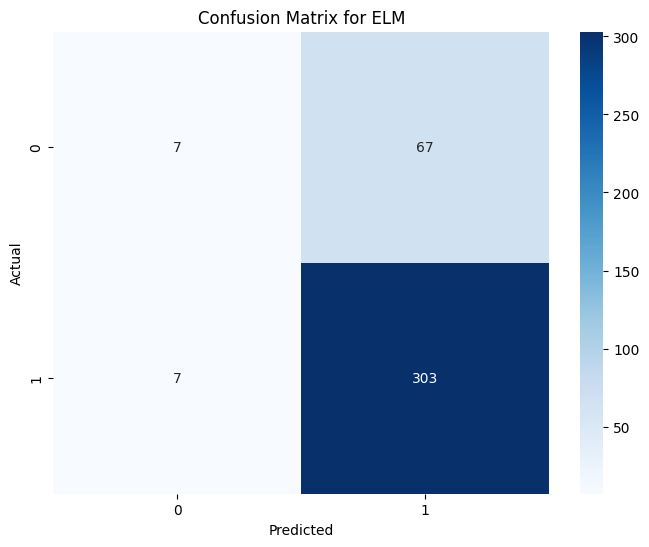

Voting Classifier Accuracy: 0.8072916666666666
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.03      0.05        74
           1       0.81      0.99      0.89       310

    accuracy                           0.81       384
   macro avg       0.66      0.51      0.47       384
weighted avg       0.75      0.81      0.73       384



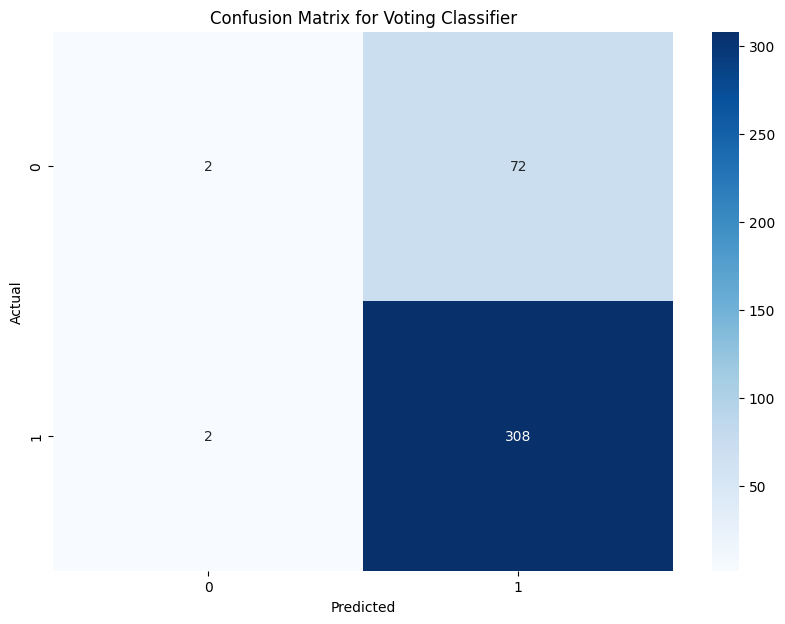

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{name} Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"{name} Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='macro')}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8 , 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(f"Voting Classifier Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
!pip install openpyxl


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 248)
Labels shape: (1279,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 0.8098958333333334
SVM Precision: 0.7388451443569554
SVM Recall: 0.5119006102877071
SVM F1 Score: 0.4731520288683819
SVM Specificity: 0.02702702702702703
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.03      0.05        74
           1       0.81      1.00      0.89       310

    accuracy                           0.81       384
   macro avg       0.74      0.51      0.47       384
weighted avg       0.78      0.81      0.73       384



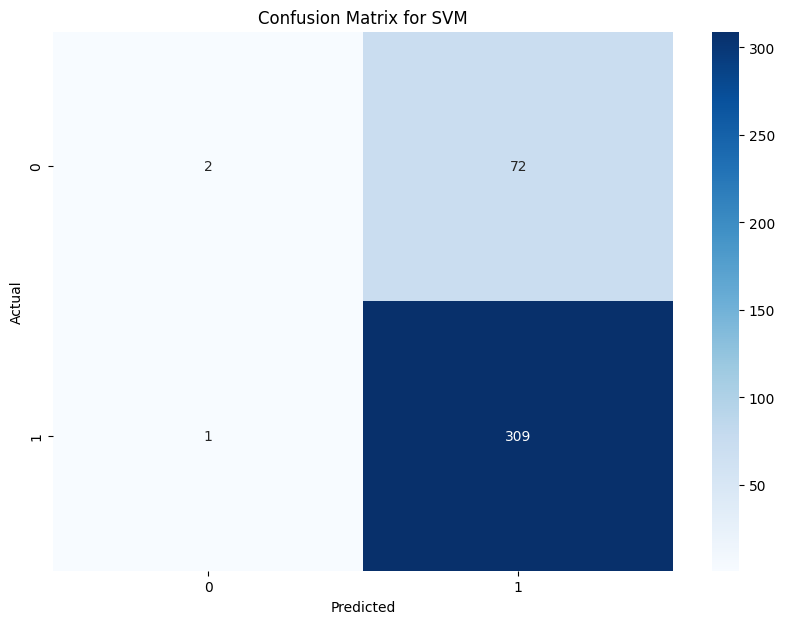

AdaBoost Accuracy: 0.7708333333333334
AdaBoost Precision: 0.5836898395721924
AdaBoost Recall: 0.5545771578029642
AdaBoost F1 Score: 0.5594263363754889
AdaBoost Specificity: 0.20270270270270271
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.20      0.25        74
           1       0.83      0.91      0.86       310

    accuracy                           0.77       384
   macro avg       0.58      0.55      0.56       384
weighted avg       0.73      0.77      0.75       384



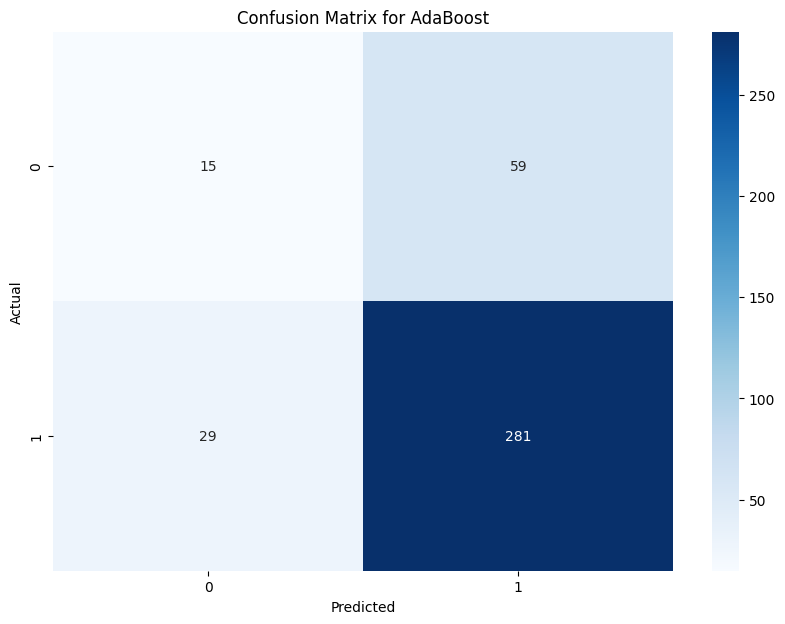

RandomForest Accuracy: 0.8072916666666666
RandomForest Precision: 0.6569148936170213
RandomForest Recall: 0.5205754141238013
RandomForest F1 Score: 0.49484462774656895
RandomForest Specificity: 0.05405405405405406
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.05      0.10        74
           1       0.81      0.99      0.89       310

    accuracy                           0.81       384
   macro avg       0.66      0.52      0.49       384
weighted avg       0.75      0.81      0.74       384



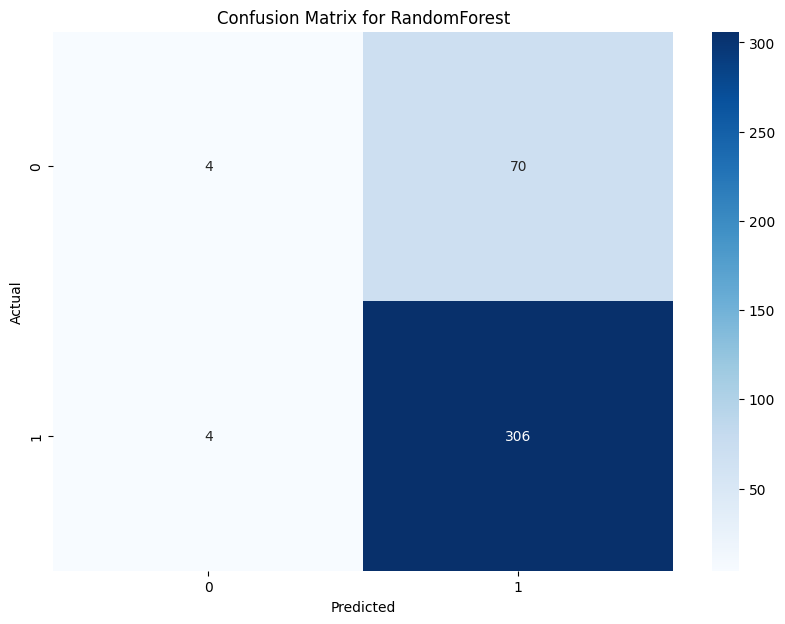

KNN Accuracy: 0.7942708333333334
KNN Precision: 0.6232751530658869
KNN Recall: 0.5588055797733217
KNN F1 Score: 0.5642318465847878
KNN Specificity: 0.17567567567567569
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.18      0.25        74
           1       0.83      0.94      0.88       310

    accuracy                           0.79       384
   macro avg       0.62      0.56      0.56       384
weighted avg       0.75      0.79      0.76       384



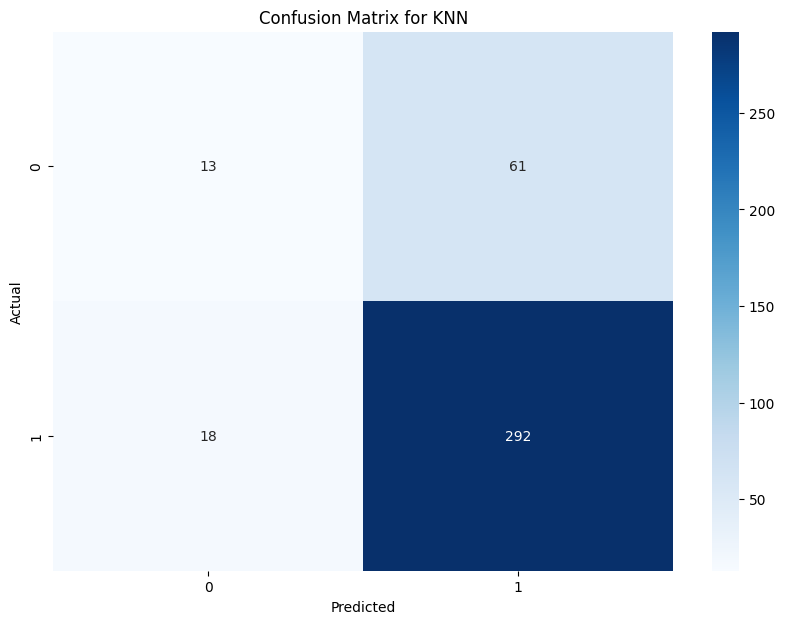

ELM Accuracy: 0.7942708333333334
ELM Precision: 0.583827536464177
ELM Recall: 0.5227986050566695
ELM F1 Score: 0.5075884233934456
ELM Specificity: 0.08108108108108109
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.08      0.13        74
           1       0.81      0.96      0.88       310

    accuracy                           0.79       384
   macro avg       0.58      0.52      0.51       384
weighted avg       0.73      0.79      0.74       384



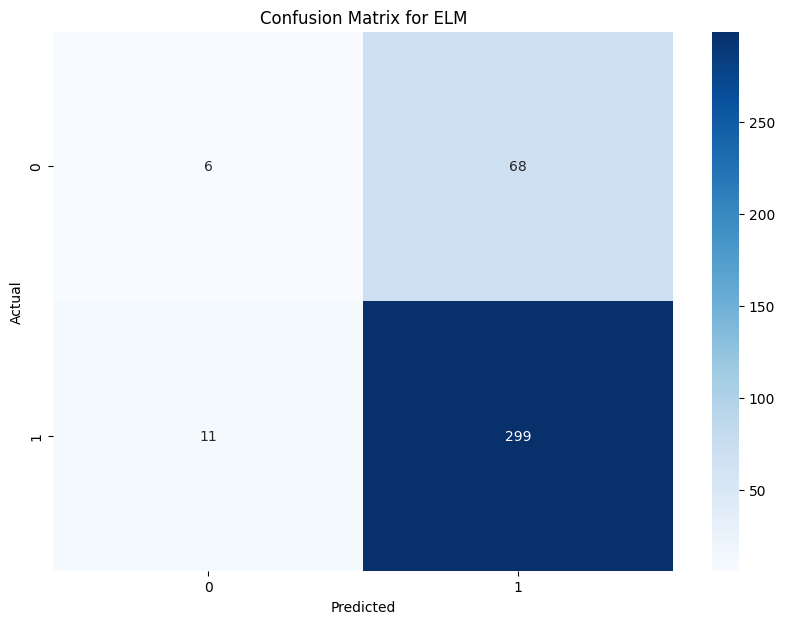

Voting Classifier Accuracy: 0.8098958333333334
Voting Classifier Specificity: 0.04054054054054054
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.04      0.08        74
           1       0.81      0.99      0.89       310

    accuracy                           0.81       384
   macro avg       0.71      0.52      0.48       384
weighted avg       0.77      0.81      0.74       384



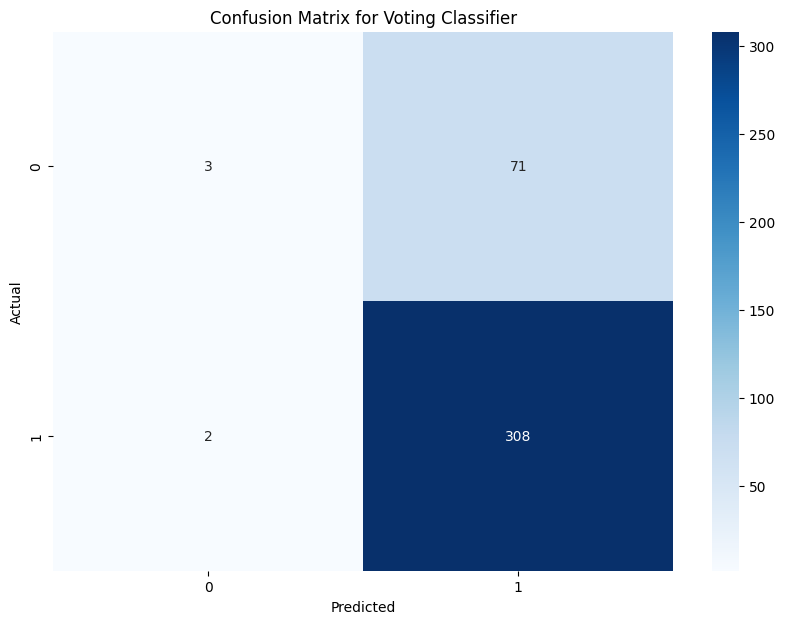

Results saved to /content/drive/MyDrive/Colab Notebooks/classification_results.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/classification_results.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 248)
Labels shape: (1279,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 0.83203125
SVM Precision: 0.915686274509804
SVM Recall: 0.5113636363636364
SVM F1 Score: 0.4761836783250059
SVM Specificity: 0.022727272727272728
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        44
           1       0.83      1.00      0.91       212

    accuracy                           0.83       256
   macro avg       0.92      0.51      0.48       256
weighted avg       0.86      0.83      0.76       256



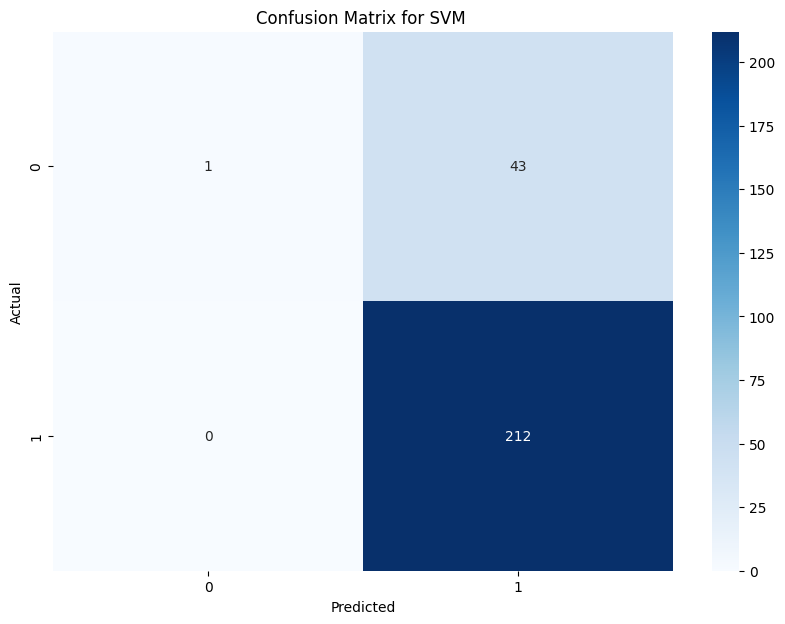

AdaBoost Accuracy: 0.78125
AdaBoost Precision: 0.5803571428571428
AdaBoost Recall: 0.5617495711835334
AdaBoost F1 Score: 0.5673587638821825
AdaBoost Specificity: 0.22727272727272727
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.23      0.26        44
           1       0.85      0.90      0.87       212

    accuracy                           0.78       256
   macro avg       0.58      0.56      0.57       256
weighted avg       0.76      0.78      0.77       256



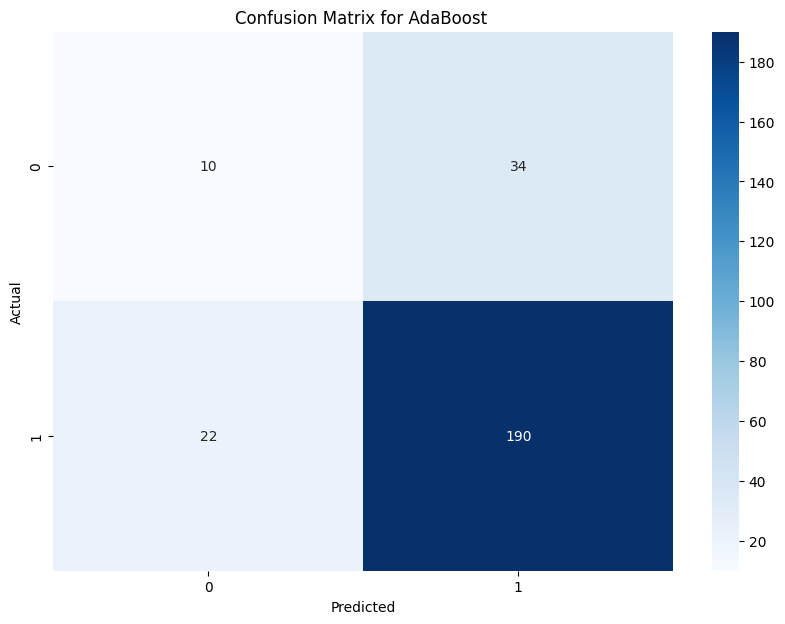

RandomForest Accuracy: 0.8359375
RandomForest Precision: 0.7936507936507937
RandomForest Recall: 0.5317324185248713
RandomForest F1 Score: 0.5172413793103449
RandomForest Specificity: 0.06818181818181818
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.07      0.12        44
           1       0.84      1.00      0.91       212

    accuracy                           0.84       256
   macro avg       0.79      0.53      0.52       256
weighted avg       0.82      0.84      0.77       256



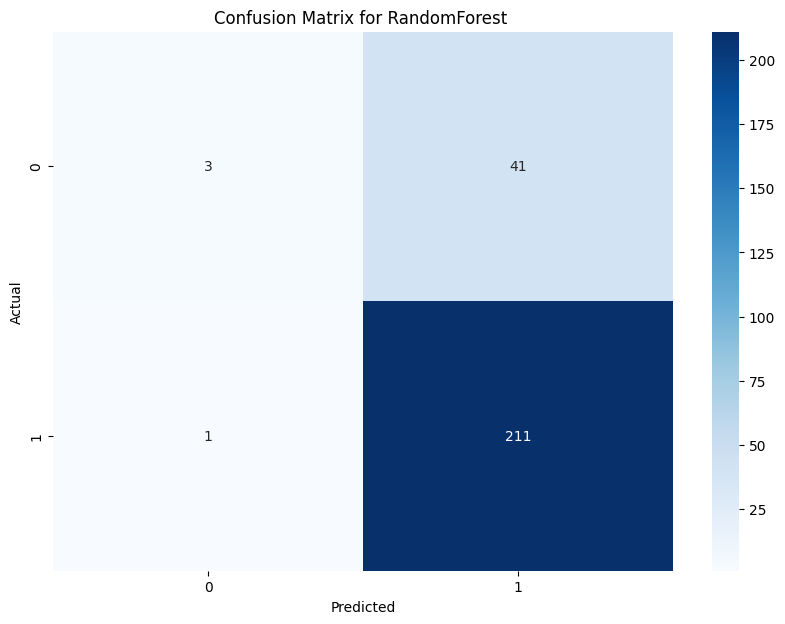

KNN Accuracy: 0.79296875
KNN Precision: 0.5620060790273556
KNN Recall: 0.5328044596912521
KNN F1 Score: 0.5330235759765961
KNN Specificity: 0.13636363636363635
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.14      0.18        44
           1       0.84      0.93      0.88       212

    accuracy                           0.79       256
   macro avg       0.56      0.53      0.53       256
weighted avg       0.74      0.79      0.76       256



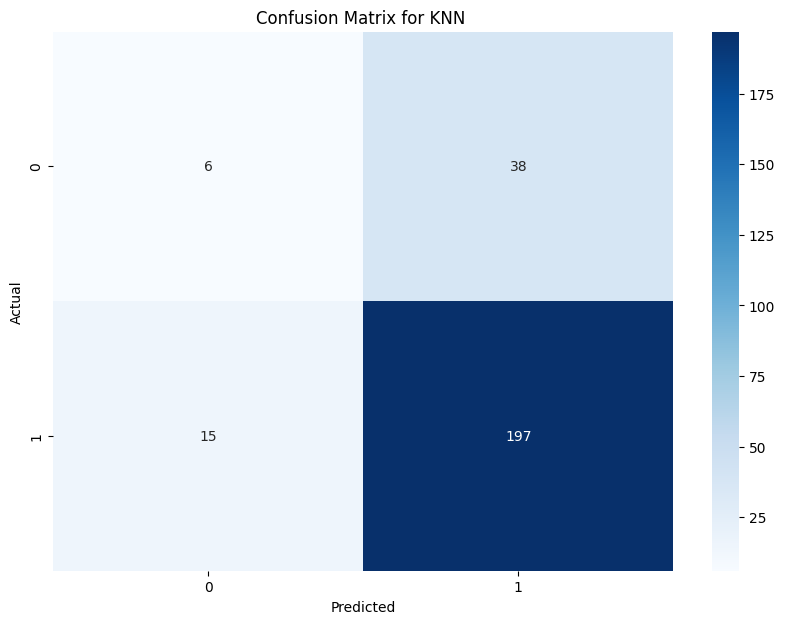

ELM Accuracy: 0.80078125
ELM Precision: 0.4685110211426001
ELM Recall: 0.49249571183533447
ELM F1 Score: 0.46331236897274636
ELM Specificity: 0.022727272727272728
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.02      0.04        44
           1       0.83      0.96      0.89       212

    accuracy                           0.80       256
   macro avg       0.47      0.49      0.46       256
weighted avg       0.70      0.80      0.74       256



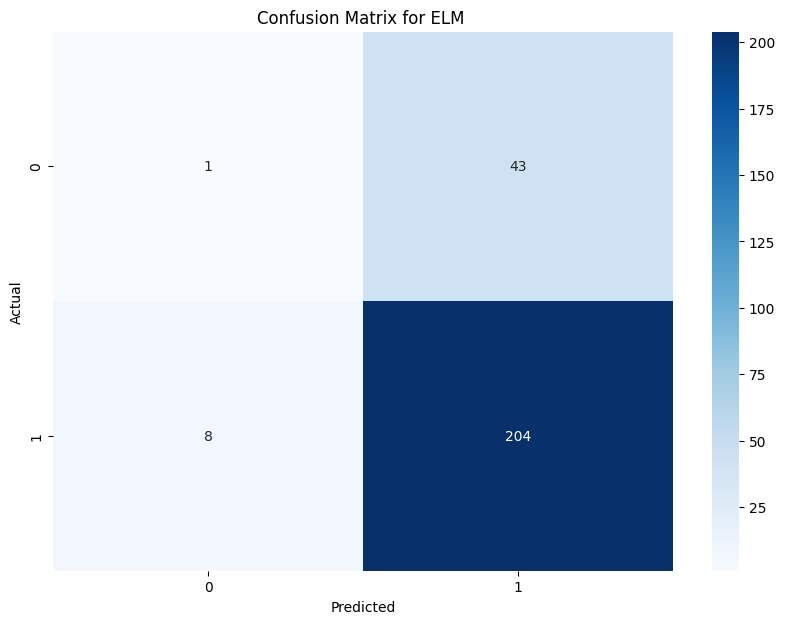

Voting Classifier Accuracy: 0.828125
Voting Classifier Specificity: 0.022727272727272728
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.04        44
           1       0.83      1.00      0.91       212

    accuracy                           0.83       256
   macro avg       0.67      0.51      0.47       256
weighted avg       0.77      0.83      0.76       256



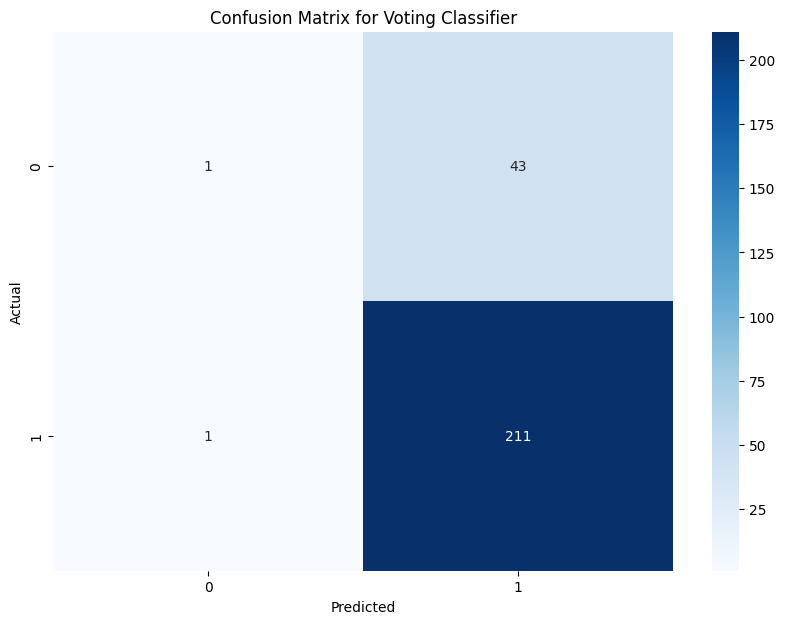

Results saved to /content/drive/MyDrive/Colab Notebooks/classification_results_20.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name} ")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/classification_results_20.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 2296)
Labels shape: (1279,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



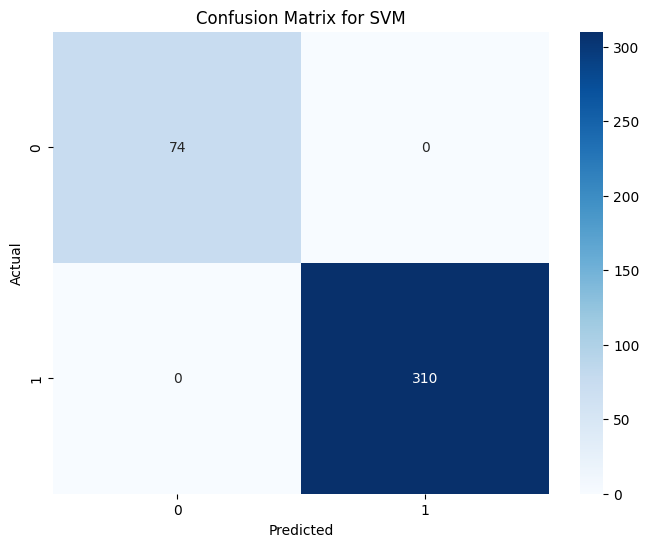

AdaBoost Accuracy: 1.0
AdaBoost Precision: 1.0
AdaBoost Recall: 1.0
AdaBoost F1 Score: 1.0
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



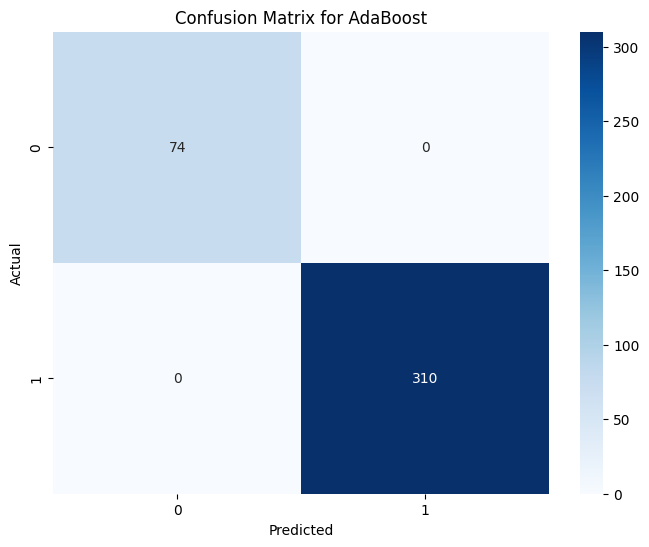

RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



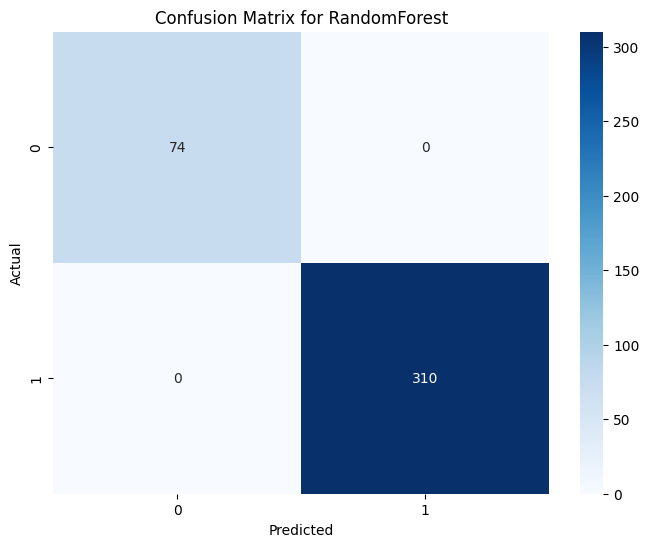

KNN Accuracy: 1.0
KNN Precision: 1.0
KNN Recall: 1.0
KNN F1 Score: 1.0
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



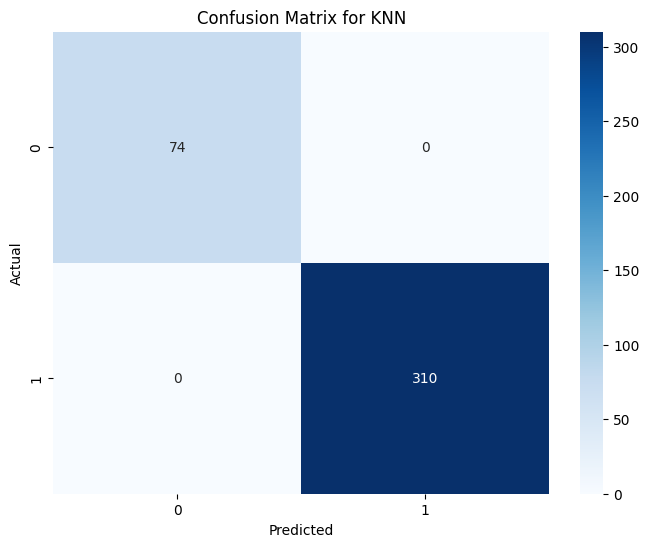

ELM Accuracy: 0.9973958333333334
ELM Precision: 0.9933333333333334
ELM Recall: 0.9983870967741936
ELM F1 Score: 0.995836540859364
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       0.99      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



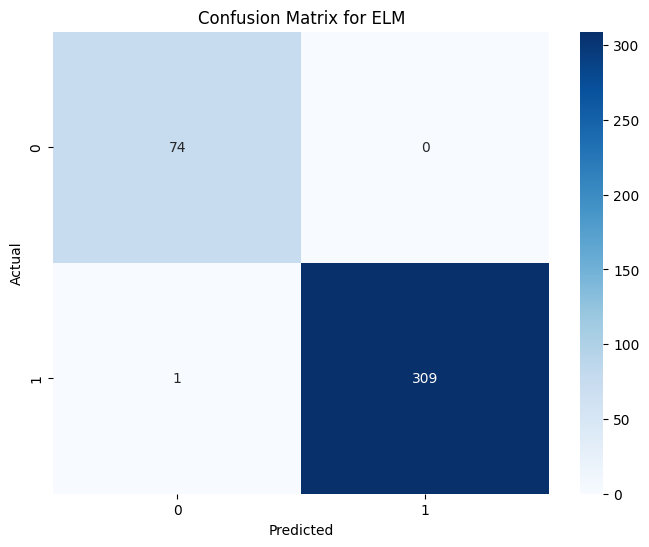

Voting Classifier Accuracy: 1.0
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



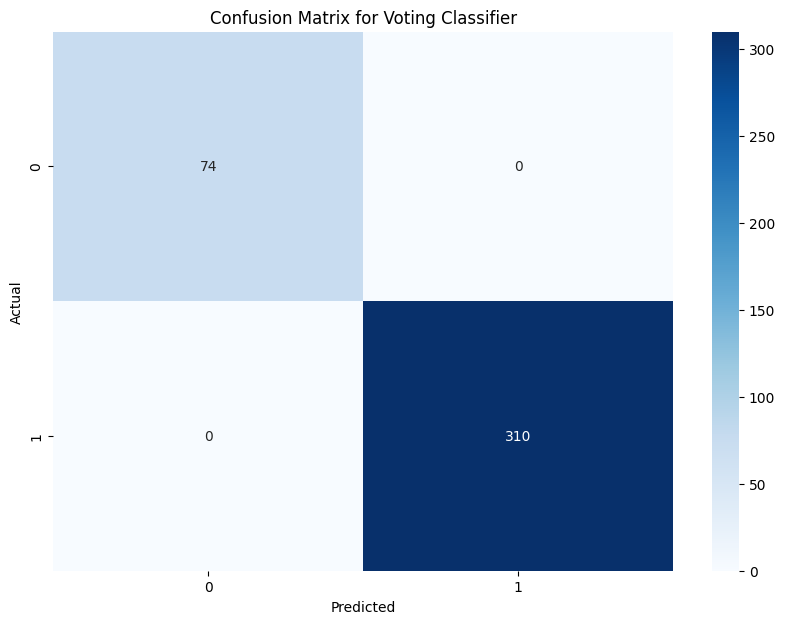

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{name} Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"{name} Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='macro')}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(f"Voting Classifier Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 2296)
Labels shape: (1279,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0
SVM Specificity: 1.0
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



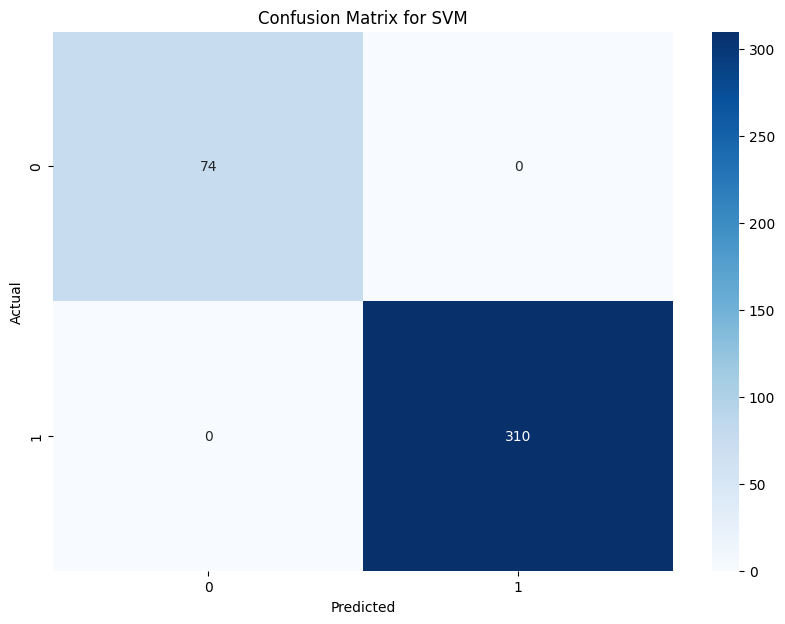

AdaBoost Accuracy: 1.0
AdaBoost Precision: 1.0
AdaBoost Recall: 1.0
AdaBoost F1 Score: 1.0
AdaBoost Specificity: 1.0
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



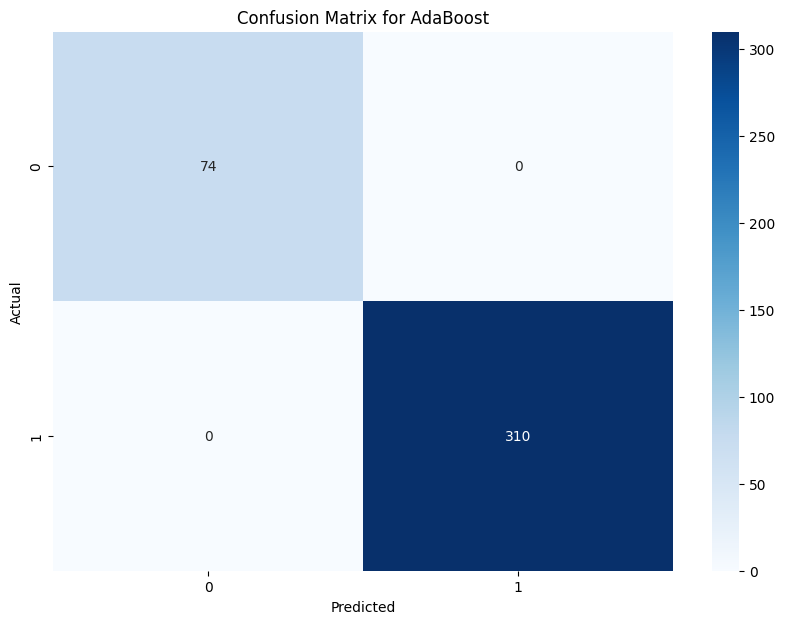

RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0
RandomForest Specificity: 1.0
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



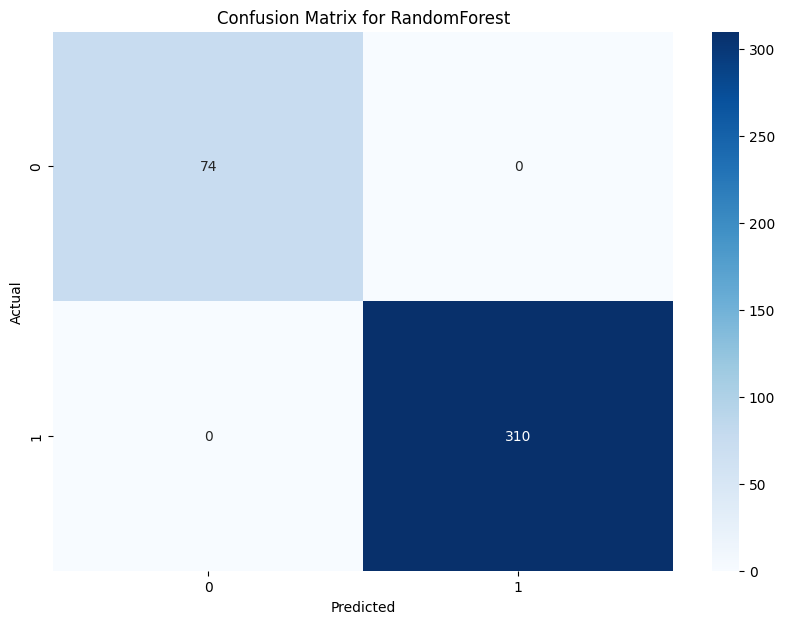

KNN Accuracy: 1.0
KNN Precision: 1.0
KNN Recall: 1.0
KNN F1 Score: 1.0
KNN Specificity: 1.0
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



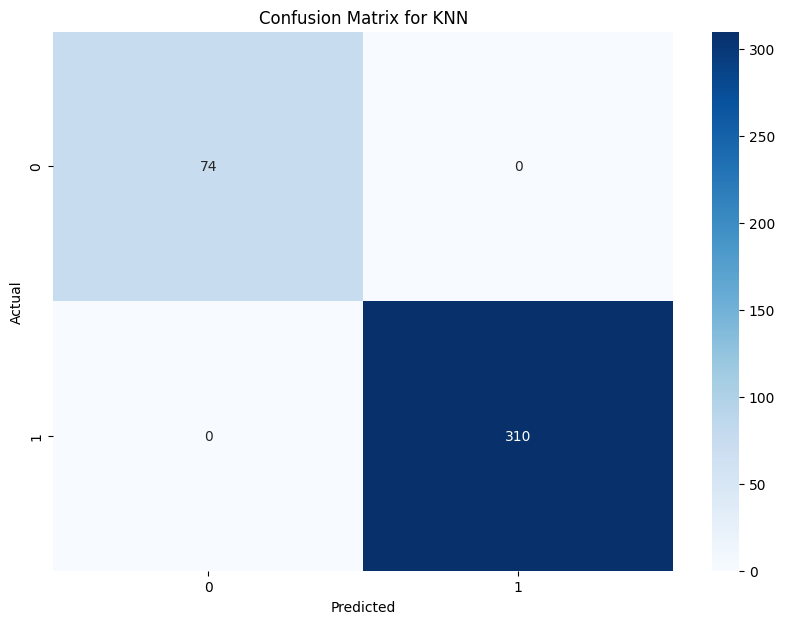

ELM Accuracy: 0.9973958333333334
ELM Precision: 0.9983922829581994
ELM Recall: 0.9932432432432432
ELM F1 Score: 0.9957934864767164
ELM Specificity: 0.9864864864864865
ELM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      0.99      1.00       384
weighted avg       1.00      1.00      1.00       384



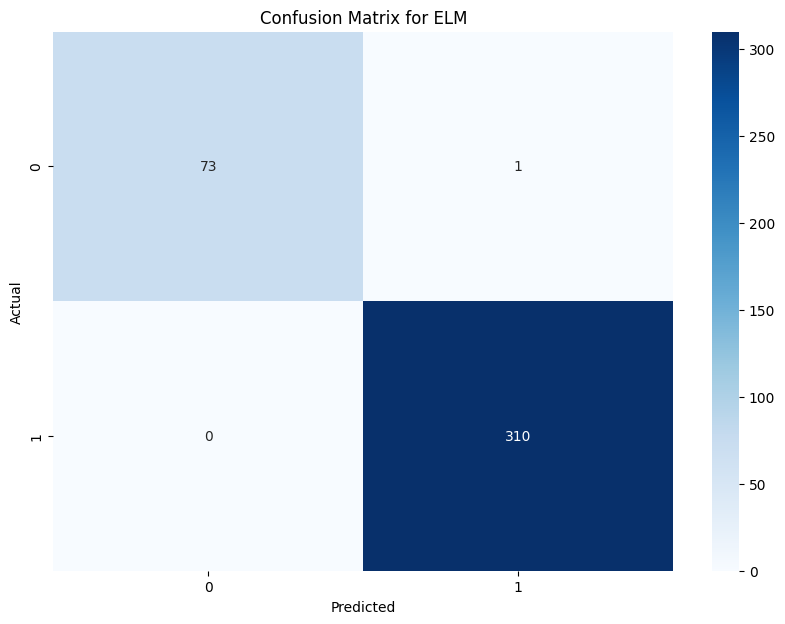

Voting Classifier Accuracy: 1.0
Voting Classifier Specificity: 1.0
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



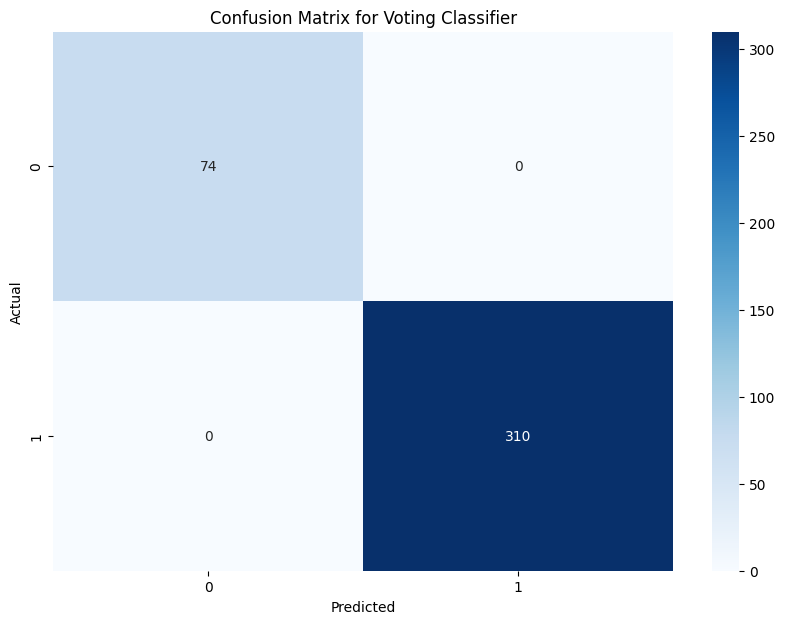

Results saved to /content/drive/MyDrive/Colab Notebooks/classification_results_all.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/classification_results_all.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1279, 2048)
Labels shape: (1279,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0
SVM Specificity: 1.0
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



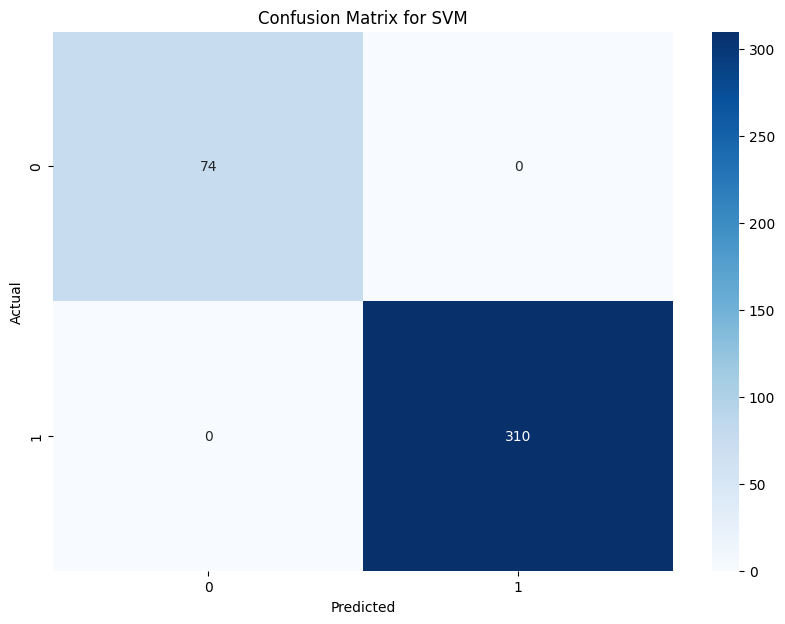

AdaBoost Accuracy: 1.0
AdaBoost Precision: 1.0
AdaBoost Recall: 1.0
AdaBoost F1 Score: 1.0
AdaBoost Specificity: 1.0
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



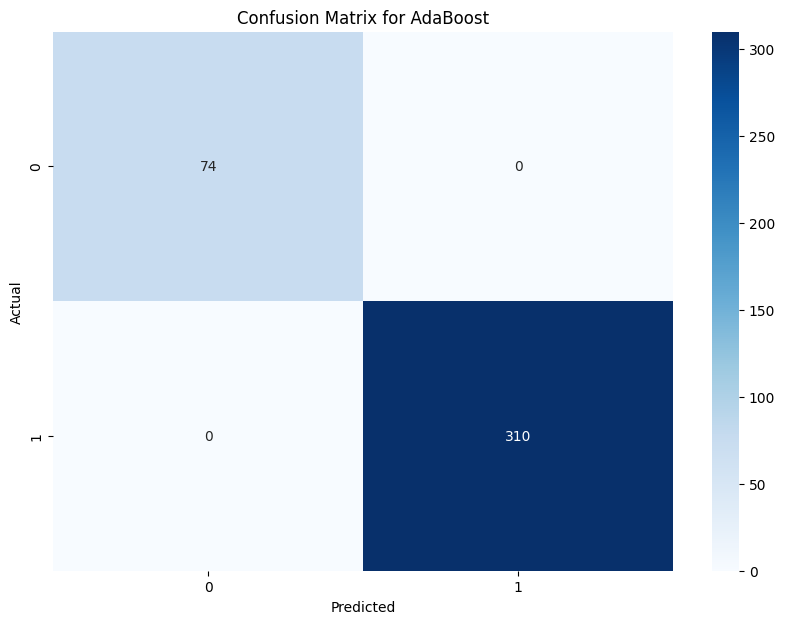

RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0
RandomForest Specificity: 1.0
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



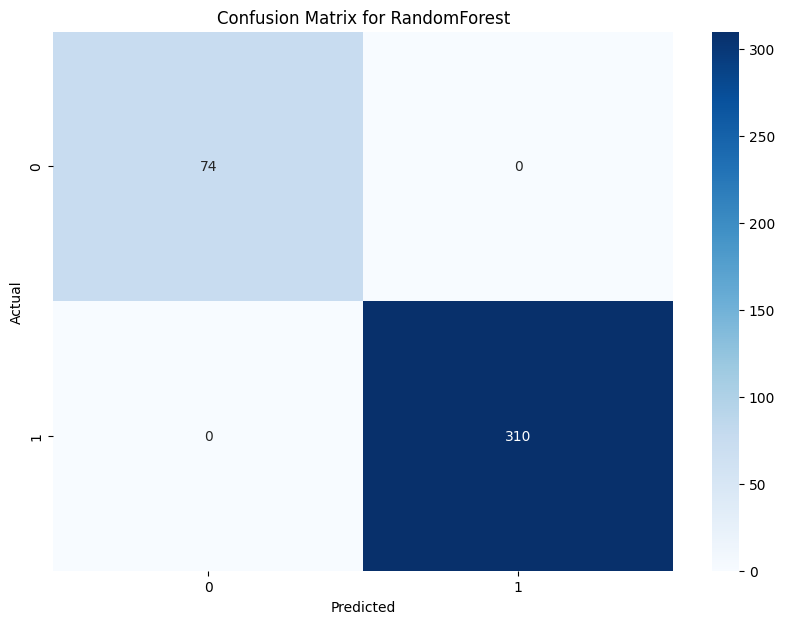

KNN Accuracy: 1.0
KNN Precision: 1.0
KNN Recall: 1.0
KNN F1 Score: 1.0
KNN Specificity: 1.0
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



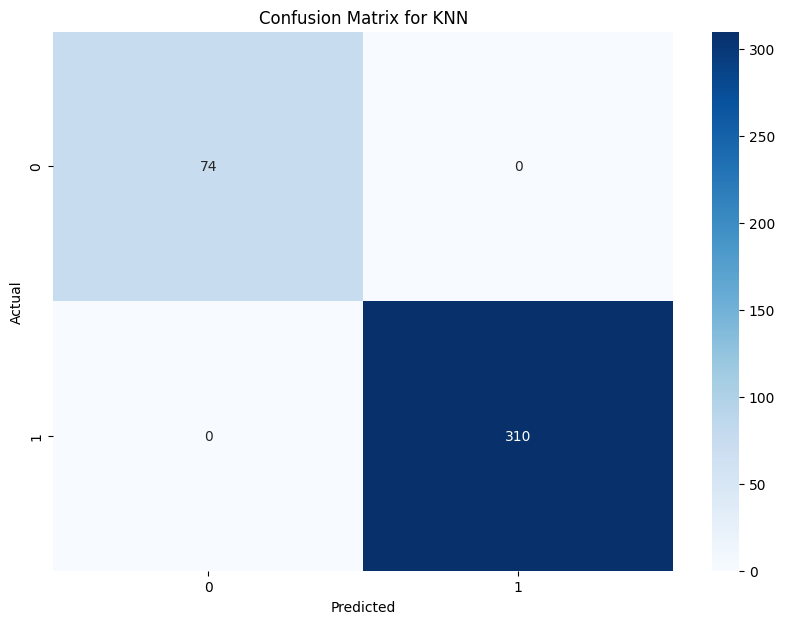

ELM Accuracy: 0.9921875
ELM Precision: 0.9850485436893204
ELM Recall: 0.9900174367916303
ELM F1 Score: 0.9875096225780919
ELM Specificity: 0.9864864864864865
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        74
           1       1.00      0.99      1.00       310

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384



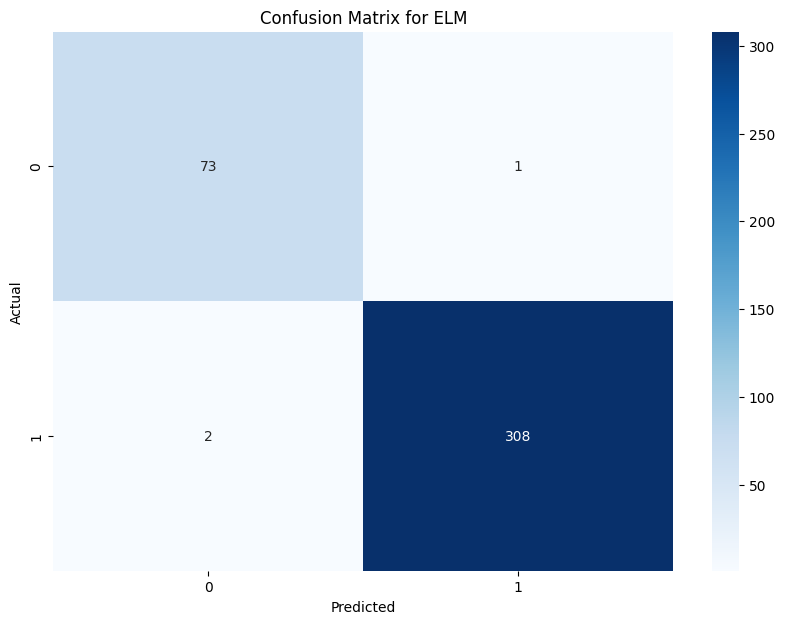

Voting Classifier Accuracy: 1.0
Voting Classifier Specificity: 1.0
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       310

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



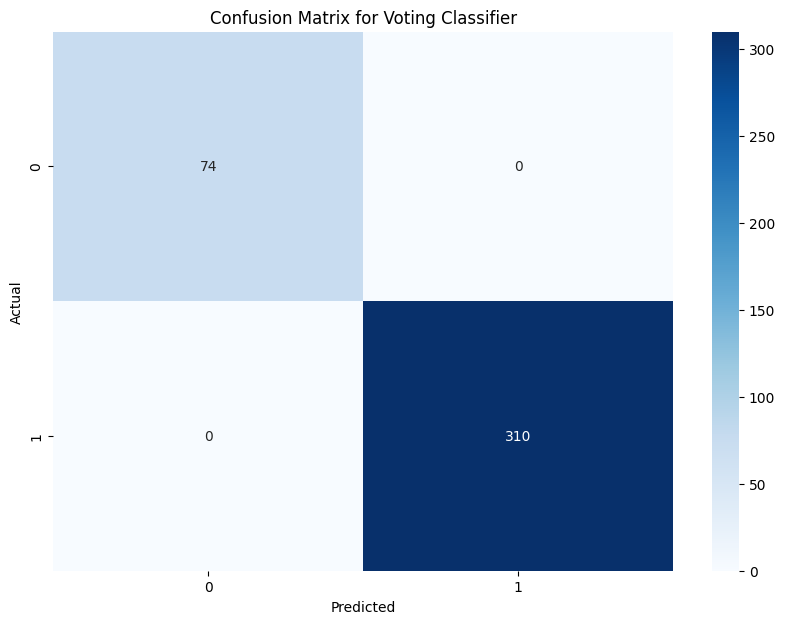

Results saved to /content/drive/MyDrive/Colab Notebooks/classification_results_all.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/bottleneck_features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/classification_results_all.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (200, 2296)
Labels shape: (200,)
SVM Accuracy: 1.0
SVM Precision: 1.0
SVM Recall: 1.0
SVM F1 Score: 1.0
SVM Specificity: 1.0
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        48

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


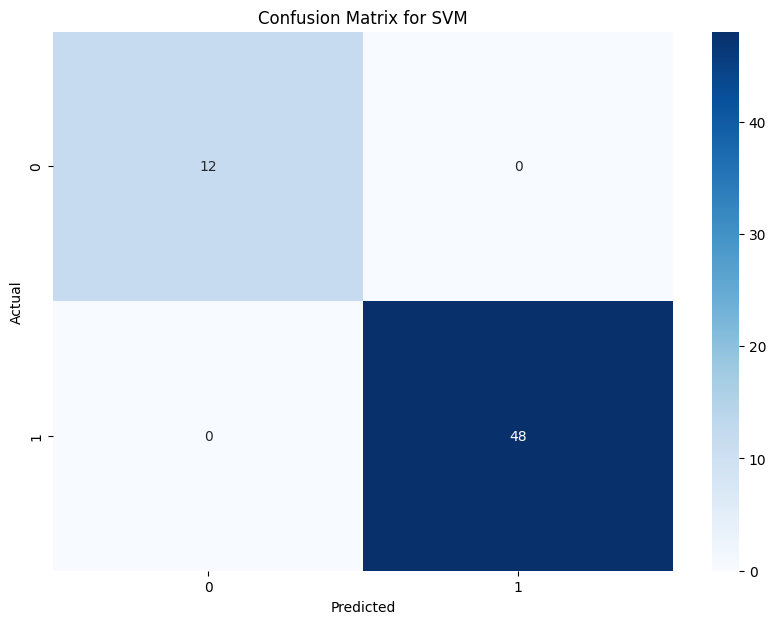

AdaBoost Accuracy: 1.0
AdaBoost Precision: 1.0
AdaBoost Recall: 1.0
AdaBoost F1 Score: 1.0
AdaBoost Specificity: 1.0
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        48

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



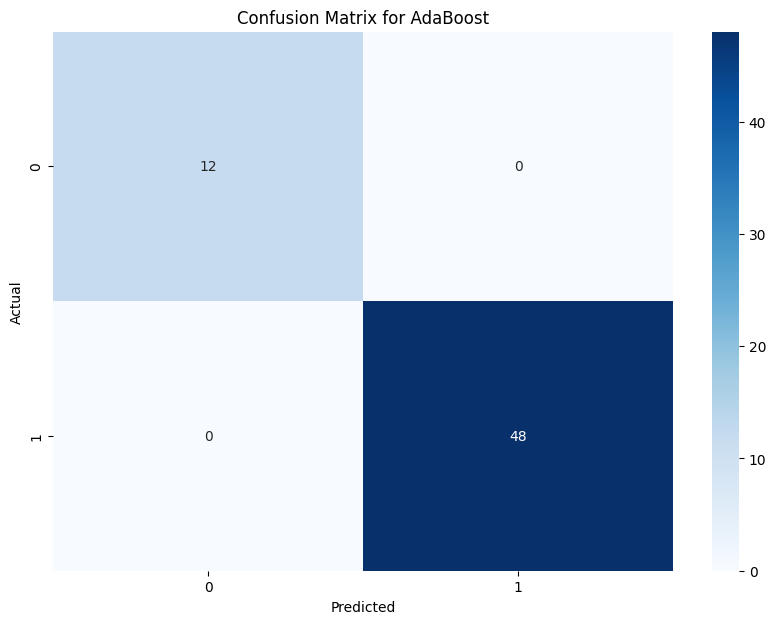

RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0
RandomForest Specificity: 1.0
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        48

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



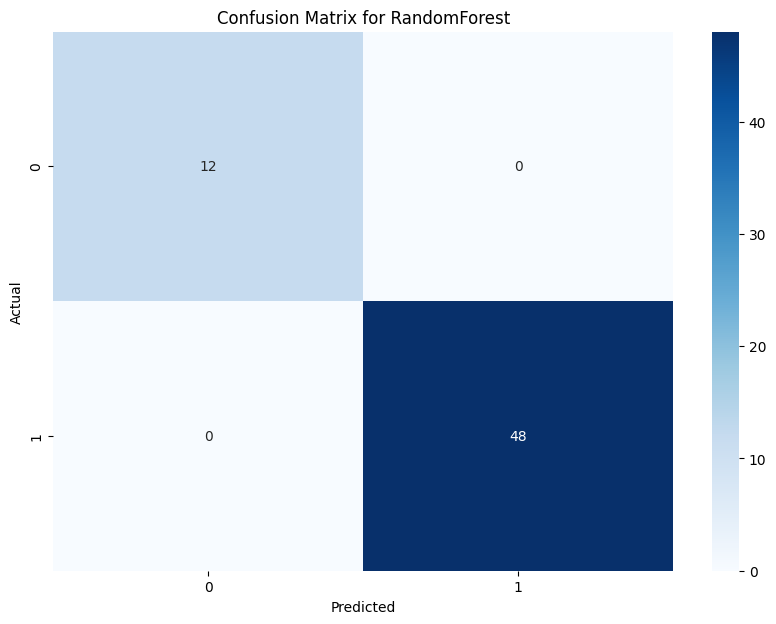

KNN Accuracy: 1.0
KNN Precision: 1.0
KNN Recall: 1.0
KNN F1 Score: 1.0
KNN Specificity: 1.0
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        48

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



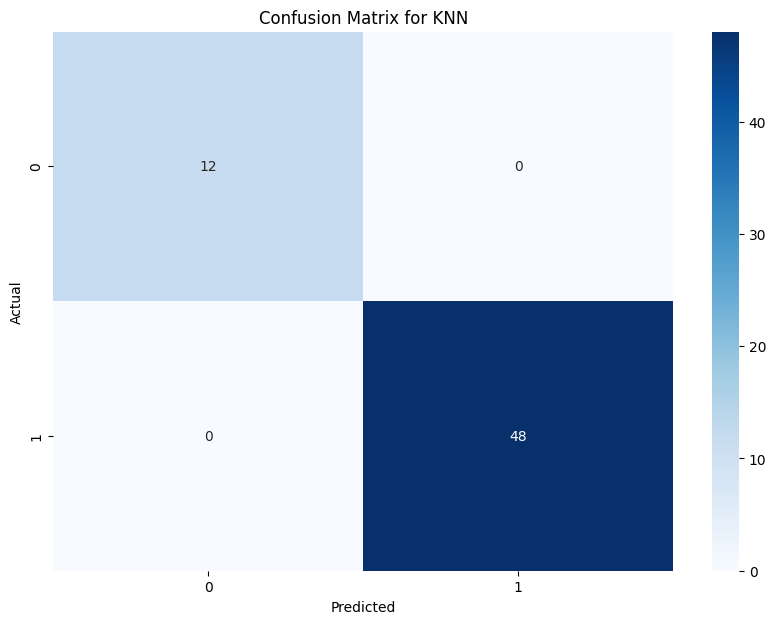

ELM Accuracy: 0.9833333333333333
ELM Precision: 0.9615384615384616
ELM Recall: 0.9895833333333333
ELM F1 Score: 0.9747368421052632
ELM Specificity: 1.0
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.98      0.99        48

    accuracy                           0.98        60
   macro avg       0.96      0.99      0.97        60
weighted avg       0.98      0.98      0.98        60



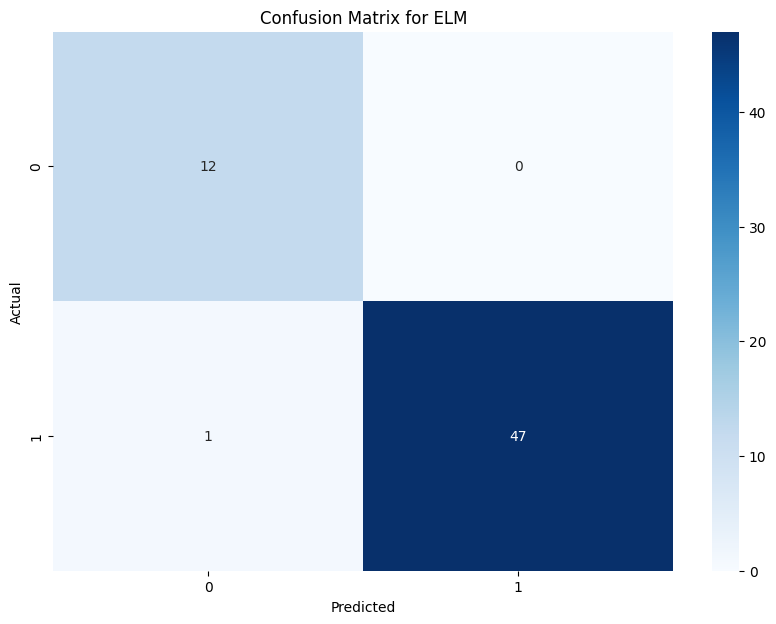

Voting Classifier Accuracy: 1.0
Voting Classifier Specificity: 1.0
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        48

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



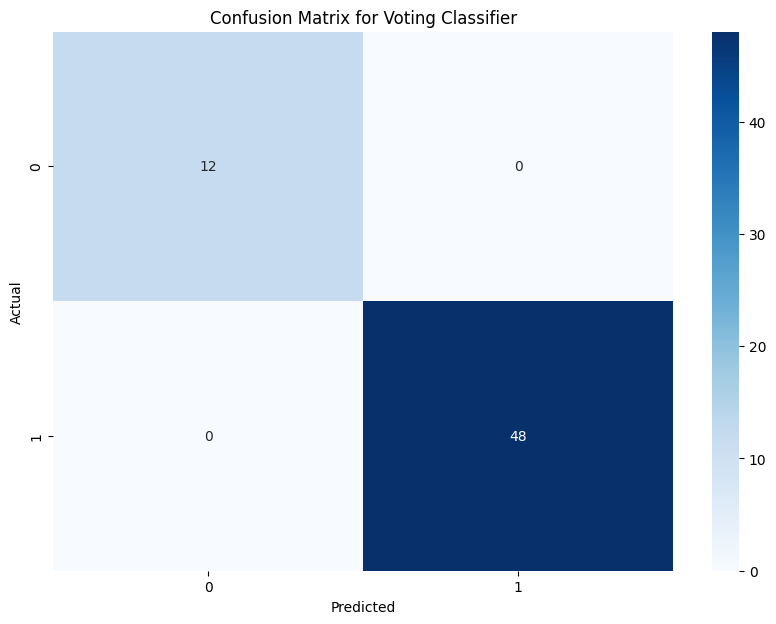

Results saved to /content/drive/MyDrive/Colab Notebooks/whole_model_ph2.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_Set/PH2_dataset/All_features.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/whole_model_ph2.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1479, 2296)
Labels shape: (1479,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 0.9977477477477478
SVM Precision: 0.9986338797814207
SVM Recall: 0.9936708860759493
SVM F1 Score: 0.9961312920961601
SVM Specificity: 0.9873417721518988
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       1.00      1.00      1.00       365

    accuracy                           1.00       444
   macro avg       1.00      0.99      1.00       444
weighted avg       1.00      1.00      1.00       444



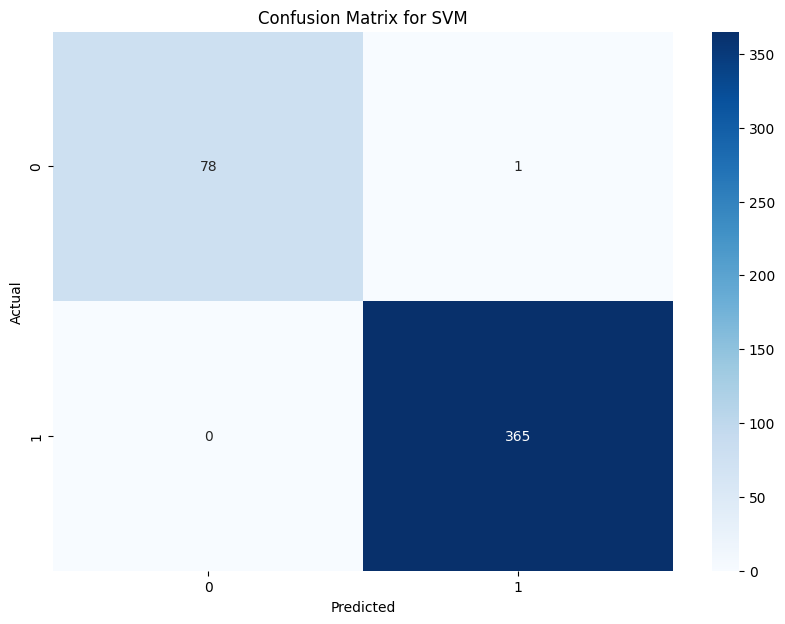

AdaBoost Accuracy: 0.9977477477477478
AdaBoost Precision: 0.9986338797814207
AdaBoost Recall: 0.9936708860759493
AdaBoost F1 Score: 0.9961312920961601
AdaBoost Specificity: 0.9873417721518988
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       1.00      1.00      1.00       365

    accuracy                           1.00       444
   macro avg       1.00      0.99      1.00       444
weighted avg       1.00      1.00      1.00       444



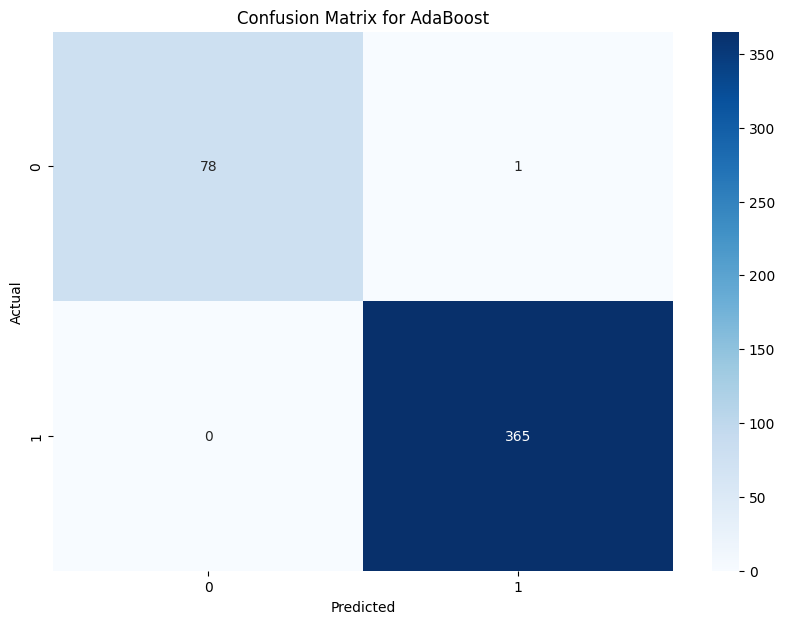

RandomForest Accuracy: 1.0
RandomForest Precision: 1.0
RandomForest Recall: 1.0
RandomForest F1 Score: 1.0
RandomForest Specificity: 1.0
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       365

    accuracy                           1.00       444
   macro avg       1.00      1.00      1.00       444
weighted avg       1.00      1.00      1.00       444



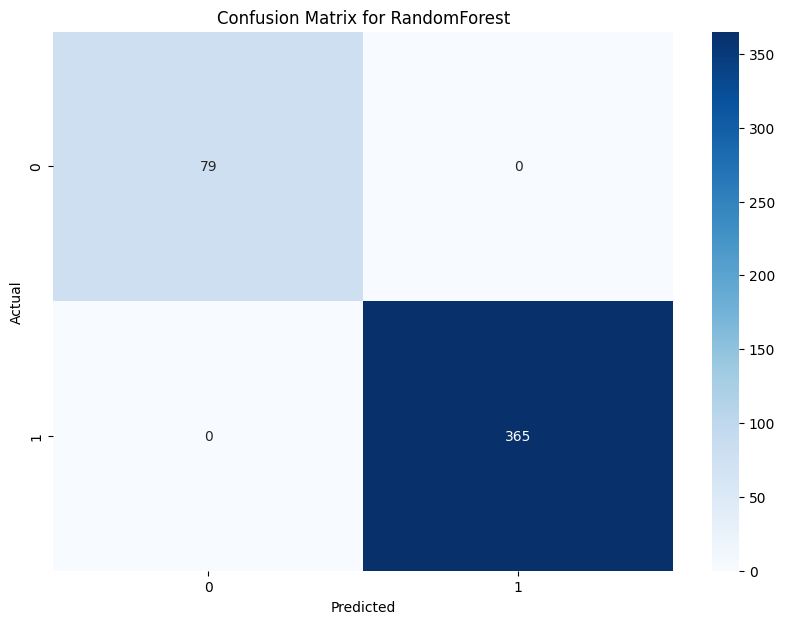

KNN Accuracy: 0.9977477477477478
KNN Precision: 0.9986338797814207
KNN Recall: 0.9936708860759493
KNN F1 Score: 0.9961312920961601
KNN Specificity: 0.9873417721518988
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       1.00      1.00      1.00       365

    accuracy                           1.00       444
   macro avg       1.00      0.99      1.00       444
weighted avg       1.00      1.00      1.00       444



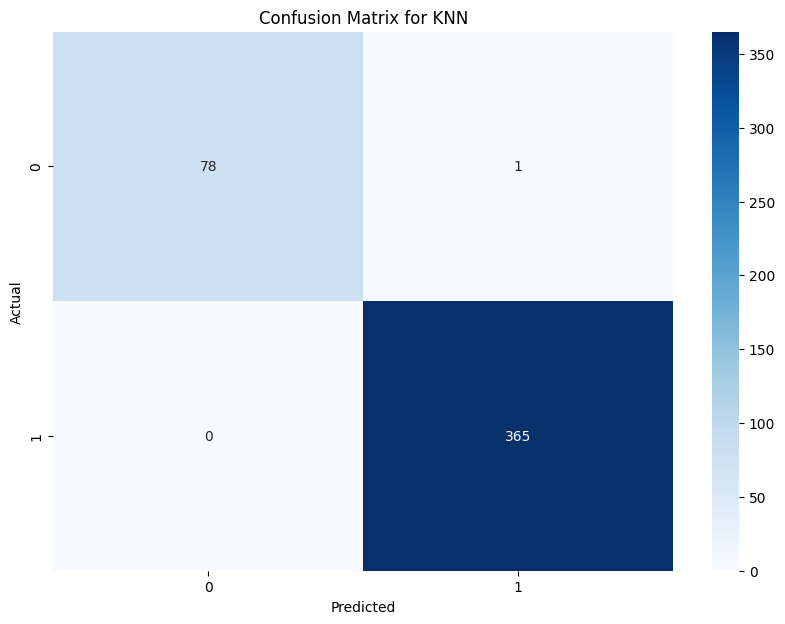

ELM Accuracy: 0.9864864864864865
ELM Precision: 0.9865582655826559
ELM Recall: 0.9669845673660482
ELM F1 Score: 0.9764322870589901
ELM Specificity: 0.9367088607594937
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        79
           1       0.99      1.00      0.99       365

    accuracy                           0.99       444
   macro avg       0.99      0.97      0.98       444
weighted avg       0.99      0.99      0.99       444



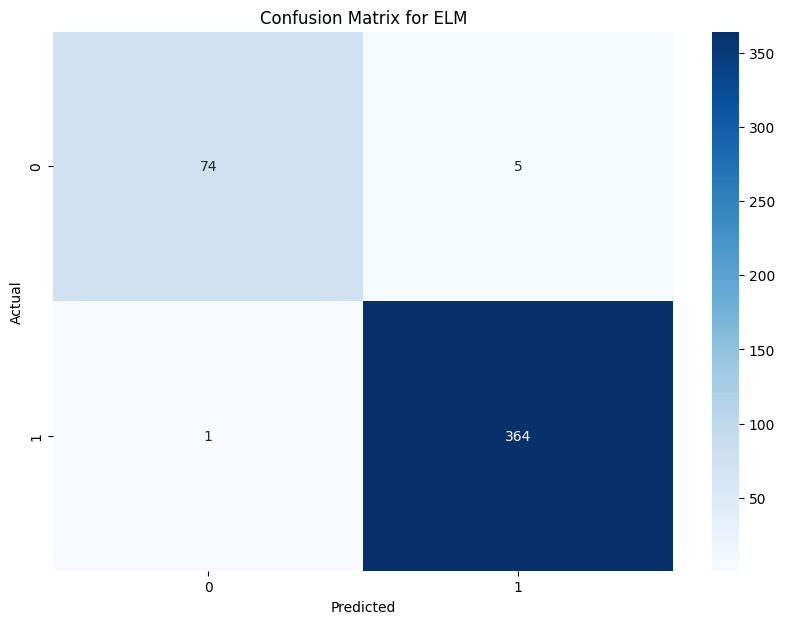

Voting Classifier Accuracy: 0.9977477477477478
Voting Classifier Specificity: 0.9873417721518988
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       1.00      1.00      1.00       365

    accuracy                           1.00       444
   macro avg       1.00      0.99      1.00       444
weighted avg       1.00      1.00      1.00       444



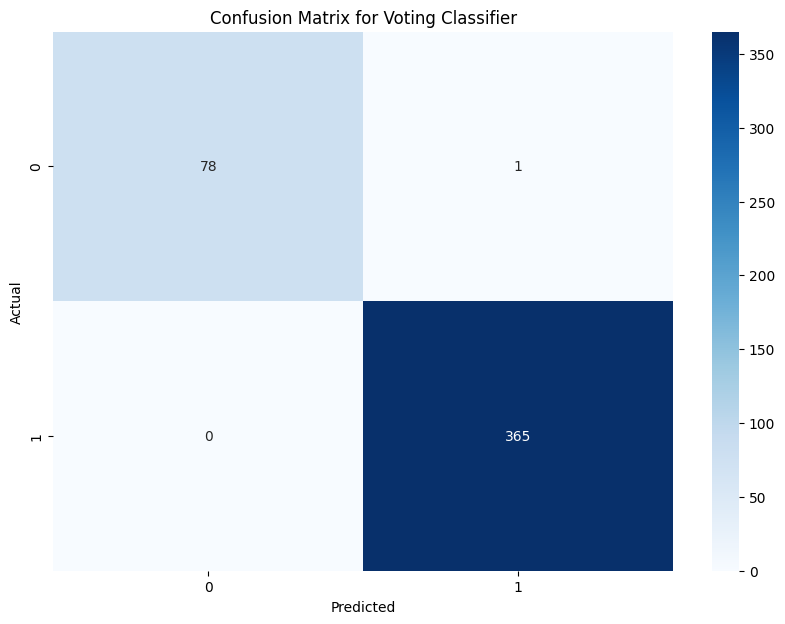

Results saved to /content/drive/MyDrive/Colab Notebooks/ALL_ISIC_PH2.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/features_ISIC_PH2.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/ALL_ISIC_PH2.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (1479, 248)
Labels shape: (1479,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


SVM Accuracy: 0.8378378378378378
SVM Precision: 0.8628352490421456
SVM Recall: 0.5492630483787064
SVM F1 Score: 0.545909090909091
SVM Specificity: 0.10126582278481013
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.10      0.18        79
           1       0.84      1.00      0.91       365

    accuracy                           0.84       444
   macro avg       0.86      0.55      0.55       444
weighted avg       0.85      0.84      0.78       444



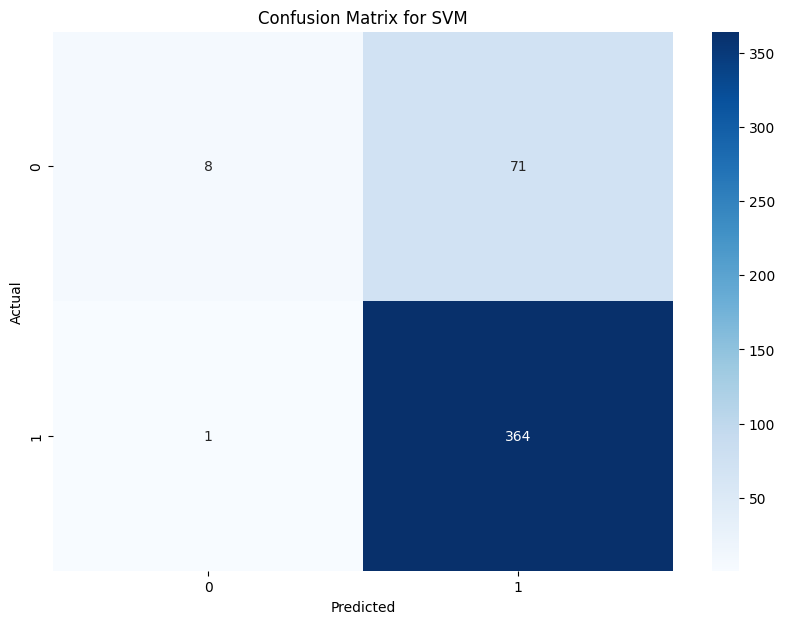

AdaBoost Accuracy: 0.8085585585585585
AdaBoost Precision: 0.6554850812935501
AdaBoost Recall: 0.6207213455869602
AdaBoost F1 Score: 0.6331898101801006
AdaBoost Specificity: 0.3291139240506329
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.33      0.38        79
           1       0.86      0.91      0.89       365

    accuracy                           0.81       444
   macro avg       0.66      0.62      0.63       444
weighted avg       0.79      0.81      0.80       444



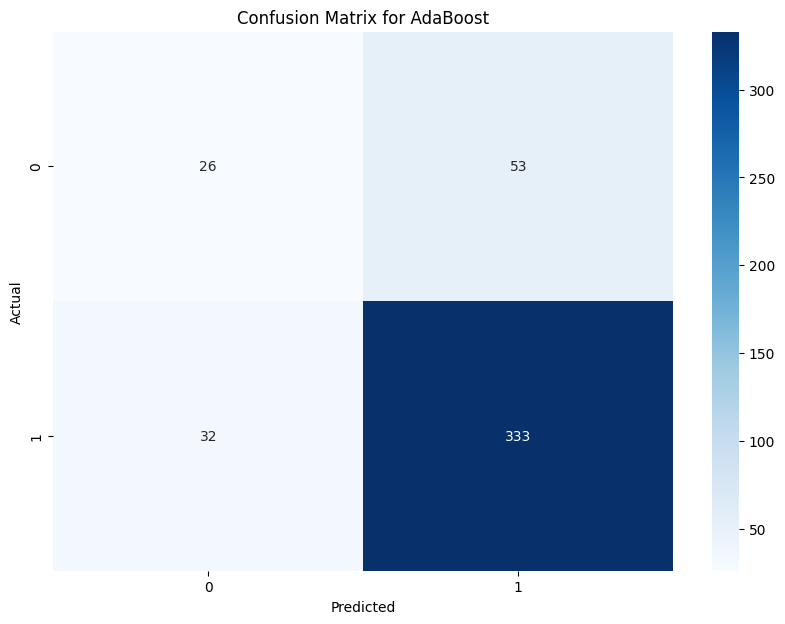

RandomForest Accuracy: 0.8400900900900901
RandomForest Precision: 0.7967289719626168
RandomForest Recall: 0.5704699150338131
RandomForest F1 Score: 0.5815490807725494
RandomForest Specificity: 0.1518987341772152
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.15      0.25        79
           1       0.84      0.99      0.91       365

    accuracy                           0.84       444
   macro avg       0.80      0.57      0.58       444
weighted avg       0.83      0.84      0.79       444



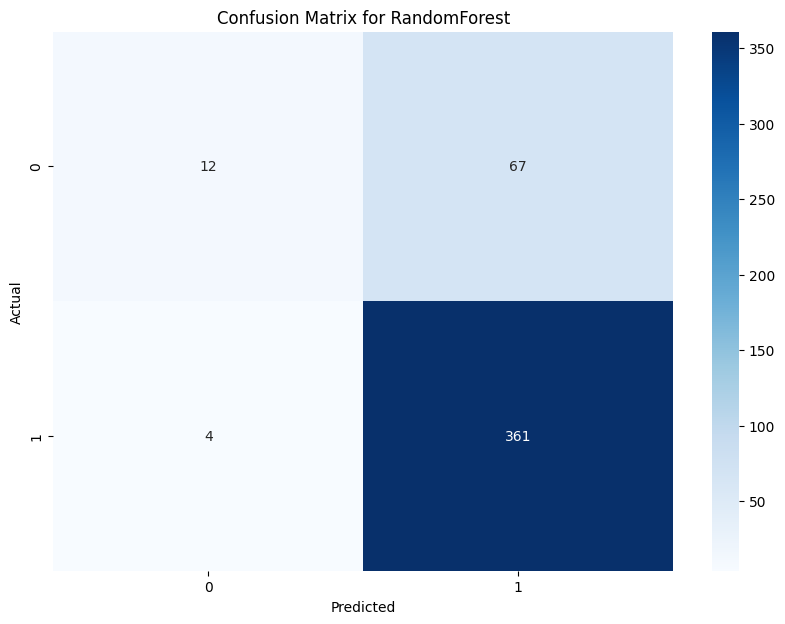

KNN Accuracy: 0.8130630630630631
KNN Precision: 0.6571969696969697
KNN Recall: 0.6036240679729495
KNN F1 Score: 0.6186948379153
KNN Specificity: 0.27848101265822783
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.28      0.35        79
           1       0.86      0.93      0.89       365

    accuracy                           0.81       444
   macro avg       0.66      0.60      0.62       444
weighted avg       0.79      0.81      0.79       444



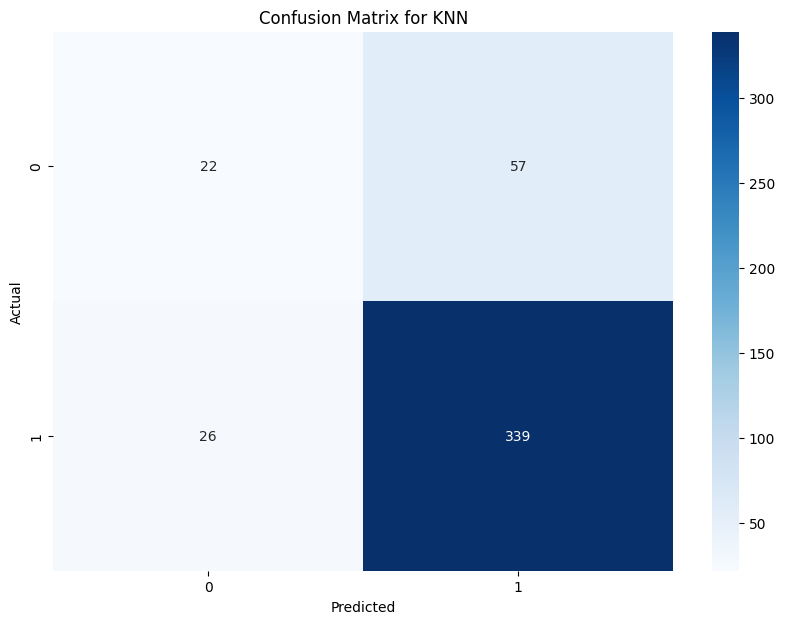

ELM Accuracy: 0.8175675675675675
ELM Precision: 0.6528159340659341
ELM Recall: 0.5617305358071787
ELM F1 Score: 0.5696387329926885
ELM Specificity: 0.16455696202531644
ELM Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.16      0.24        79
           1       0.84      0.96      0.90       365

    accuracy                           0.82       444
   macro avg       0.65      0.56      0.57       444
weighted avg       0.77      0.82      0.78       444



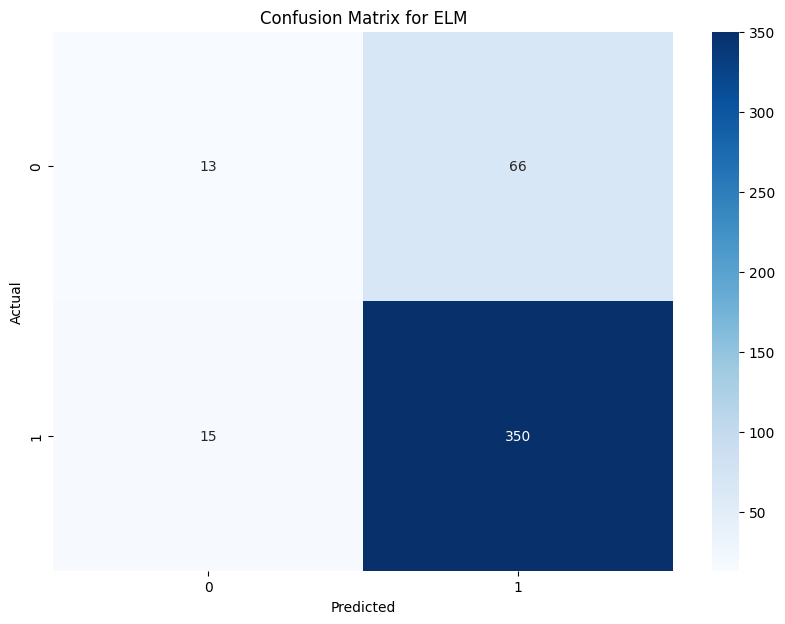

Voting Classifier Accuracy: 0.8490990990990991
Voting Classifier Specificity: 0.24050632911392406
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.24      0.36        79
           1       0.86      0.98      0.91       365

    accuracy                           0.85       444
   macro avg       0.79      0.61      0.64       444
weighted avg       0.83      0.85      0.82       444



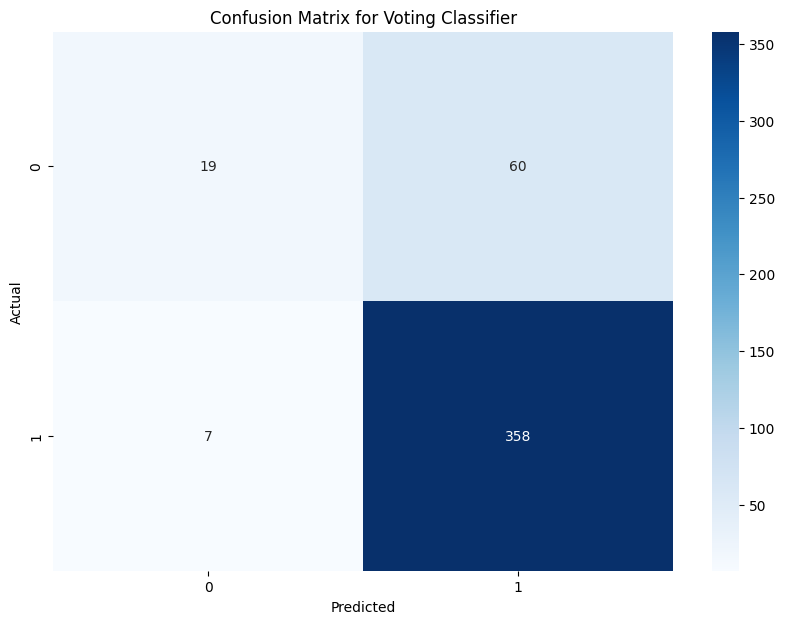

Results saved to /content/drive/MyDrive/Colab Notebooks/ALL_ISIC_PH2_branch1.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from hpelm import ELM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl

# Path to your Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/statistical_features_PH2_ISIC.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Drop the first column (image_name)
df = df.drop(columns=[df.columns[0]])

# Assuming the last column is the label
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Display the shape of the feature matrix and labels to confirm
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels for ELM
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define models
svm = SVC(kernel='rbf', probability=True)
adaboost = AdaBoostClassifier(n_estimators=100)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=5)

# Define ELM model
elm = ELM(X_train.shape[1], y_train_encoded.shape[1])
elm.add_neurons(100, 'sigm')  # Add 100 sigmoid neurons

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Train and evaluate models
models = [("SVM", svm), ("AdaBoost", adaboost), ("RandomForest", rf), ("KNN", knn), ("ELM", elm)]
results = []

for name, model in models:
    if name == "ELM":
        model.train(X_train, y_train_encoded)
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'Classification Report': report,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print(f"{name} Specificity: {specificity}")
    print(f"{name} Classification Report:\n{report}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Optionally, combine models into a voting classifier (excluding ELM due to different interface)
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models if name != "ELM"], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred)
voting_specificity = calculate_specificity(y_test, y_pred)
voting_report = classification_report(y_test, y_pred)

results.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'Specificity': voting_specificity,
    'Classification Report': voting_report,
    'Confusion Matrix': confusion_matrix(y_test, y_pred)
})

print(f"Voting Classifier Accuracy: {voting_accuracy}")
print(f"Voting Classifier Specificity: {voting_specificity}")
print(f"Voting Classifier Classification Report:\n{voting_report}")

# Compute and plot confusion matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Export results to Excel
output_file_path = '/content/drive/MyDrive/Colab Notebooks/ALL_ISIC_PH2_branch1.xlsx'

# Create a new Excel workbook and sheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Write the header
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Classification Report']
ws.append(headers)

# Write the data
for result in results:
    ws.append([result['Model'], result['Accuracy'], result['Precision'], result['Recall'], result['F1 Score'], result['Specificity'], result['Classification Report']])

# Save the workbook
wb.save(output_file_path)
print(f"Results saved to {output_file_path}")
